
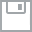
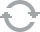
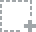
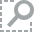
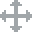
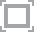
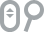
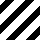
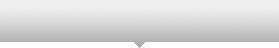
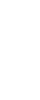
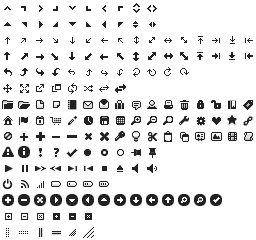
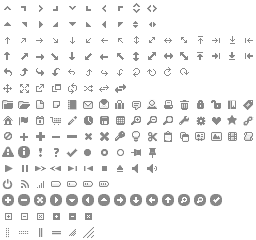
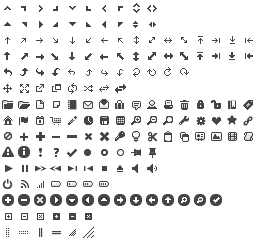
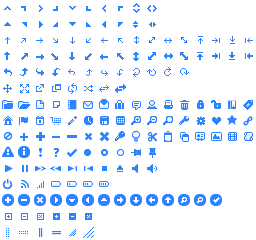
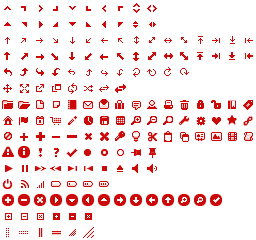
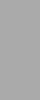
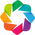
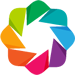

In [39]:
import pandas as pd
import numpy as np
import datetime as dt
import dill, wget
from geopy import geocoders   # geocoding by search address
import geocoder
import os, simplejson, requests
from pandas.io.json import json_normalize
from sqlalchemy import create_engine, sql   # database connection
from collections import OrderedDict
from time import sleep    # time delay
from __future__ import division   # force float division
from IPython.display import display

from sklearn import cross_validation, grid_search
from sklearn.linear_model import LinearRegression, ElasticNetCV, ElasticNet, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion

from bokeh.plotting import figure, vplot, hplot
from bokeh.embed import components
from bokeh.charts import Bar, output_file, show, Histogram, Scatter
#_legacy_charts requires bokeh version == 0.10.0
from bokeh._legacy_charts import Bar as BBar
from bokeh._legacy_charts import HeatMap
from bokeh.palettes import YlOrRd9 as palette
from bokeh.io import output_notebook, vform
from bokeh.models import CustomJS, ColumnDataSource, HoverTool
from bokeh.models.widgets import TextInput, CheckboxButtonGroup, RadioButtonGroup, Dropdown, Select, Panel, Tabs

%matplotlib inline
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

output_notebook()

In [40]:
# Initialize database obtained through API (NYC_Restaurant_Inspection_API.db) in current directory
disk_engine = create_engine('sqlite:///NYC_Restaurant_Inspection_API.db') 
# Initialize database with filename NYC_Restaurant_Inspection_web.db in current directory to store analyzed results
# for fast access when building the website
disk_output = create_engine('sqlite:///NYC_Restaurant_Inspection_web.db') 

# Define function for Preprocessing Data Consistently

We only use data from 2013-2015. df0 is the subset that only includes "Cycle Inspections" & "Pre-permit Inspections"

In [4]:
def preprocessing(df):
    if 'BORO' in df.columns:
        df = df[df.BORO != 'Missing']
        df.loc[:,'BORO']=df['BORO'].astype(str) 
    if 'INSPECTION_DATE' in df.columns:
        #convert Inspection date to datetime
        df.loc[:,'Date'] = pd.to_datetime(df['INSPECTION_DATE'])
        df = df.drop('INSPECTION_DATE', 1)
        #add Year column
        df.loc[:,'Year'] = df.Date.dt.year
        #only use 2012-2015 datasets
        df = df[df.Year >=2012]
    if 'CUISINE_DESCRIPTION' in df.columns:
        #fix the unicode for easier processing
        fix1=df['CUISINE_DESCRIPTION'].str.replace(u'CafÃ©/Coffee/Tea','Cafe/Coffee/Tea')
        fix2=fix1.str.replace(u'Café/Coffee/Tea','Cafe/Coffee/Tea')
        fix3=fix2.apply(lambda x: 'Latin' if str(x).startswith('Latin') else str(x) )
        df.loc[:,'Cuisine']=fix3.astype(str) 
        df=df.drop('CUISINE_DESCRIPTION',axis=1)
    #replace NaN with 'None'
    if 'GRADE' in df.columns:
        df.loc[:,'GRADE']=df.GRADE.fillna('None')
    if 'VIOLATION_CODE' in df.columns:
        df.loc[:,'VIOLATION_CODE']=df.VIOLATION_CODE.fillna('None')
        df.loc[:,'VIOLATION_CODE']=df['VIOLATION_CODE'].astype(str) 
    if 'SCORE' in df.columns:
        df.loc[:,'SCORE']=df.SCORE.fillna('None')
    if 'GRADE_DATE' in df.columns:
        df.loc[:,'GRADE_DATE']=df.GRADE_DATE.fillna('None')
   
    df.loc[:,'INSPECTION_TYPE']=df.INSPECTION_TYPE.fillna('None')
    df = df[df.INSPECTION_TYPE!='None']
    dft = df
    # for df, df0 only use 2013-2015 data
    df = df[df.Year>=2013]
    # df0: data only from "Cycle Inspections" & "Pre-permit (Operational) Inspections"
    df0=df[df.INSPECTION_TYPE.str.startswith('Cycle')|
           (df.INSPECTION_TYPE.str.startswith('Pre')&df.INSPECTION_TYPE.str.contains('Operational'))]
    return df, df0, dft    

# I. General Analysis

In [41]:
dr = pd.read_sql_query('SELECT CAMIS, CUISINE_DESCRIPTION, BORO, CRITICAL_FLAG, INSPECTION_TYPE, INSPECTION_DATE '
                       'FROM data', disk_engine)

In [42]:
df, df0, dft = preprocessing(dr)
df0.head()

,CAMIS,BORO,CRITICAL_FLAG,INSPECTION_TYPE,Date,Year,Cuisine
0,30075445,BRONX,Critical,Cycle Inspection / Initial Inspection,2015-02-09,2015,Bakery
1,30075445,BRONX,Not Critical,Cycle Inspection / Initial Inspection,2014-03-03,2014,Bakery
3,30075445,BRONX,Critical,Cycle Inspection / Re-inspection,2013-09-11,2013,Bakery
4,30075445,BRONX,Critical,Cycle Inspection / Re-inspection,2013-09-11,2013,Bakery
5,30075445,BRONX,Critical,Cycle Inspection / Initial Inspection,2013-08-14,2013,Bakery


## I-1. Number of restaurants inspected per borough in year 2013 - 2015

In [44]:
#unique restaurants inspected in every year
dfnr = df0.drop_duplicates(['CAMIS','Year']) 
dfnr = pd.concat([dfnr['BORO'], dfnr['Year'], dfnr['CAMIS']], axis=1, keys=['Borough', 'Year','Number of Restaurants'])
nr=dfnr.groupby(['Borough','Year']).count()
nr_plot = nr.reset_index()

p = Bar(nr_plot, label=
        'Borough', values='Number of Restaurants', group='Year',
        title="Number of Resteraunts inspected", width=500, height=500,  legend='top_right')

show(p)

## I-2. Number of critical flags per borough in year 2013-2015

In [49]:
df0.groupby('CRITICAL_FLAG').count().CAMIS #'Not Applicable' are those inspections not resulting in any violations

CRITICAL_FLAG
Critical          234084
Not Applicable      1462
Not Critical      160821
Name: CAMIS, dtype: int64

In [533]:
#count only violations
dfnv = df0[df0.CRITICAL_FLAG != 'Not Applicable'] 
dfnv = pd.concat([dfnv['BORO'], dfnv['Year'], dfnv['CRITICAL_FLAG']], axis=1,
                 keys=['Borough', 'Year','Flag'])
nv = dfnv.groupby(['Borough','Year']).count()
nc = dfnv[dfnv.Flag == 'Critical'].groupby(['Borough','Year']).count()
dfnvcr = pd.concat([nc['Flag'], nv['Flag'], nr['Number of Restaurants']], axis=1,
                  keys=['Number of Critical Flags', 'Number of Violaitons', 'Number of Restaurants'])
#calculations
dfnvcr.loc[:,'Violations per Restaurant']=dfnvcr['Number of Violaitons']/dfnvcr['Number of Restaurants']
dfnvcr.loc[:,'% of Critical Flags']=dfnvcr['Number of Critical Flags']/dfnvcr['Number of Violaitons']
dfnvcr.loc[:,'Critical Violations per Restaurant']=dfnvcr['Number of Critical Flags']/dfnvcr['Number of Restaurants']
dfnvcr=dfnvcr.reset_index()
dfnvcr

,Borough,Year,Number of Critical Flags,Number of Violaitons,Number of Restaurants,Violations per Restaurant,% of Critical Flags,Critical Violations per Restaurant
0,BRONX,2013,6711,11416,1644,6.944039,0.587859,4.082117
1,BRONX,2014,6481,11315,1962,5.767074,0.572779,3.303262
2,BRONX,2015,7244,12563,2192,5.731296,0.576614,3.304745
3,BROOKLYN,2013,16792,28016,4056,6.907298,0.599372,4.140039
4,BROOKLYN,2014,18684,32149,4931,6.519773,0.581169,3.789089
5,BROOKLYN,2015,20109,34119,5565,6.130997,0.589378,3.613477
6,MANHATTAN,2013,30972,51318,7303,7.026975,0.603531,4.240997
7,MANHATTAN,2014,32343,54677,8603,6.355574,0.591528,3.759502
8,MANHATTAN,2015,32029,53750,9226,5.825927,0.595888,3.471602
9,QUEENS,2013,17118,28454,3805,7.478055,0.601603,4.498817


In [11]:
p2 = Bar(dfnvcr, label='Borough', values='Critical Violations per Restaurant', group='Year',
        title="Number of Critical Violations per Restaurant",
        width=500, height=500, legend='top_right')

show(p2) 

# II. Grade and Score Distributions Among Boros and Cuisine Types

## II-1. Cleaning data (2012-2015)

In [45]:
dr = pd.read_sql_query('SELECT CAMIS, DBA, BORO, CUISINE_DESCRIPTION, GRADE, SCORE, INSPECTION_DATE, '
                       'INSPECTION_TYPE '
                       'FROM data ', disk_engine)
dr.head()

,CAMIS,DBA,BORO,CUISINE_DESCRIPTION,GRADE,SCORE,INSPECTION_DATE,INSPECTION_TYPE
0,30075445,MORRIS PARK BAKE SHOP,BRONX,Bakery,A,6,2015-02-09 00:00:00.000000,Cycle Inspection / Initial Inspection
1,30075445,MORRIS PARK BAKE SHOP,BRONX,Bakery,A,2,2014-03-03 00:00:00.000000,Cycle Inspection / Initial Inspection
2,30075445,MORRIS PARK BAKE SHOP,BRONX,Bakery,None,None,2013-10-10 00:00:00.000000,Trans Fat / Second Compliance Inspection
3,30075445,MORRIS PARK BAKE SHOP,BRONX,Bakery,A,6,2013-09-11 00:00:00.000000,Cycle Inspection / Re-inspection
4,30075445,MORRIS PARK BAKE SHOP,BRONX,Bakery,A,6,2013-09-11 00:00:00.000000,Cycle Inspection / Re-inspection


In [46]:
dgs, dgs0, dgst =preprocessing(dr)

In [14]:
# show all inspection types in 'Cycle' and 'Pre-permit' inspections
dgs0.groupby('INSPECTION_TYPE').size()

INSPECTION_TYPE
Cycle Inspection / Compliance Inspection                     2167
Cycle Inspection / Initial Inspection                      237794
Cycle Inspection / Re-inspection                           116231
Cycle Inspection / Reopening Inspection                      3827
Cycle Inspection / Second Compliance Inspection                57
Pre-permit (Operational) / Compliance Inspection             1063
Pre-permit (Operational) / Initial Inspection               23127
Pre-permit (Operational) / Re-inspection                    11401
Pre-permit (Operational) / Reopening Inspection               645
Pre-permit (Operational) / Second Compliance Inspection        55
dtype: int64

In [15]:
dgs0.CAMIS.unique().shape[0]  # number of unique CAMIS in the database from 2012-2015

24470

## II-2. Final grade (A, B, C) analysis

### II-2.1 Cleaning data (A, B, C), and number of restaurants (CAMIS) per cuisine type

In [16]:
#only consider final grade of A B or C, discard pending grades P and Z
dg0abc=dgs0[((dgs0.GRADE=='A')|(dgs0.GRADE=='B')|(dgs0.GRADE=='C'))] 
#get rid of duplicates resulted from different violations
drfg=dg0abc.drop_duplicates(subset=['CAMIS', 'Date']) 
drfg.head(2)

,CAMIS,DBA,BORO,GRADE,SCORE,INSPECTION_TYPE,Date,Year,Cuisine
0,30075445,MORRIS PARK BAKE SHOP,BRONX,A,6,Cycle Inspection / Initial Inspection,2015-02-09,2015,Bakery
1,30075445,MORRIS PARK BAKE SHOP,BRONX,A,2,Cycle Inspection / Initial Inspection,2014-03-03,2014,Bakery


In [17]:
drfg.groupby('INSPECTION_TYPE').size()

INSPECTION_TYPE
Cycle Inspection / Compliance Inspection               1
Cycle Inspection / Initial Inspection              30733
Cycle Inspection / Re-inspection                   43008
Cycle Inspection / Reopening Inspection              422
Pre-permit (Operational) / Initial Inspection       2968
Pre-permit (Operational) / Re-inspection            4270
Pre-permit (Operational) / Reopening Inspection       71
dtype: int64

In [55]:
# number of restaurants (CAMIS) per cuisine type
drr=drfg[['Cuisine','CAMIS']]
drr=drr.drop_duplicates('CAMIS').groupby('Cuisine').size().to_frame(name='Counts')
drr=drr.sort('Counts',ascending=False)

### II-2.2 Final grades distributions among top 22 cuisines in a certain year

In [32]:
def finalgrade(year, drfg):
    # selecting a certain year's data
    drfg_year=drfg[drfg['Year']==year]  
    # cuisine grades in a certain year
    drfg_cuisine_year=drfg_year.groupby(['Cuisine','GRADE']).size().unstack().fillna(0)
    drfg_cuisine_year['Total']=drfg_cuisine_year['A']+drfg_cuisine_year['B']+drfg_cuisine_year['C']
    drfg_cuisine_year['number_of_restaurants']=drr
    drfg_cuisine_year=drfg_cuisine_year.sort('number_of_restaurants',ascending=False)
    #calculate percentages of each grade in each cuisine type
    drfg_cuisine_year['A%']=drfg_cuisine_year['A']/drfg_cuisine_year['Total']
    drfg_cuisine_year['B%']=drfg_cuisine_year['B']/drfg_cuisine_year['Total']
    drfg_cuisine_year['C%']=drfg_cuisine_year['C']/drfg_cuisine_year['Total']
    
    #selecting the top 22 cuisine types with the most number of restaurants
    top=22
    drfg_cuisine_yeartop=drfg_cuisine_year.reset_index().head(top)
    # define the list of top 22 cuisines with the most number of restaurants
    top22cuisines=drfg_cuisine_yeartop.Cuisine.tolist()
    
    # sort with most number of grades
    drfg_cuisine_yeartopn=drfg_cuisine_yeartop.sort('Total',ascending=False)
    # get the cuisines and we group the data by grade
    cuisine = drfg_cuisine_yeartopn['Cuisine'].astype(str).tolist()
    A = drfg_cuisine_yeartopn['A'].astype(float).values
    C = drfg_cuisine_yeartopn['C'].astype(float).values
    B = drfg_cuisine_yeartopn['B'].astype(float).values
    
    # sort them according to the percentages of A grade
    drfg_cuisine_yeartop=drfg_cuisine_yeartop.sort('A%',ascending=False)
    # get the cuisines and we group the data by grade
    cuisine2 = drfg_cuisine_yeartop['Cuisine'].astype(str).tolist()
    A2 = drfg_cuisine_yeartop['A%'].astype(float).values
    B2 = drfg_cuisine_yeartop['B%'].astype(float).values
    C2 = drfg_cuisine_yeartop['C%'].astype(float).values
    
    return top22cuisines, cuisine, A, B, C, cuisine2, A2, B2, C2

In [56]:
top22cuisines, cuisine_2013, A_2013, B_2013, C_2013, cuisine2_2013, A2_2013, B2_2013, C2_2013 = finalgrade(2013, drfg)
top22cuisines, cuisine_2014, A_2014, B_2014, C_2014, cuisine2_2014, A2_2014, B2_2014, C2_2014 = finalgrade(2014, drfg)
top22cuisines, cuisine_2015, A_2015, B_2015, C_2015, cuisine2_2015, A2_2015, B2_2015, C2_2015 = finalgrade(2015, drfg)

In [35]:
dfgcuisines = pd.DataFrame({'top22cuisines_2013': top22cuisines_2013,
                            'cuisine_2013': cuisine_2013,
                            'A_2013': A_2013,
                            'B_2013': B_2013,
                            'C_2013': C_2013,
                            'cuisine2_2013': cuisine2_2013,
                            'A2_2013': A2_2013,
                            'B2_2013': B2_2013,
                            'C2_2013': C2_2013,
                            'top22cuisines_2014': top22cuisines_2014,
                            'cuisine_2014': cuisine_2014,
                            'A_2014': A_2014,
                            'B_2014': B_2014,
                            'C_2014': C_2014,
                            'cuisine2_2014': cuisine2_2014,
                            'A2_2014': A2_2014,
                            'B2_2014': B2_2014,
                            'C2_2014': C2_2014,
                            'top22cuisines_2015': top22cuisines_2015,
                            'cuisine_2015': cuisine_2015,
                            'A_2015': A_2015,
                            'B_2015': B_2015,
                            'C_2015': C_2015,
                            'cuisine2_2015': cuisine2_2015,
                            'A2_2015': A2_2015,
                            'B2_2015': B2_2015,
                            'C2_2015': C2_2015,
                            })
dfgcuisines.to_sql('dfgcuisines', disk_output, if_exists='replace')

In [51]:
# Read from data table in disk_output engine
dfgcuisines = pd.read_sql_query('SELECT * FROM dfgcuisines', disk_output)

top22cuisines = dfgcuisines.top22cuisines_2013.tolist()
cuisine_2013 = dfgcuisines.cuisine_2013.tolist()
A_2013 = dfgcuisines.A_2013.tolist()
B_2013 = dfgcuisines.B_2013.tolist()
C_2013 = dfgcuisines.C_2013.tolist()
cuisine2_2013 = dfgcuisines.cuisine2_2013.tolist()
A2_2013 = dfgcuisines.A2_2013.tolist()
B2_2013 = dfgcuisines.B2_2013.tolist()
C2_2013 = dfgcuisines.C2_2013.tolist()
cuisine_2014 = dfgcuisines.cuisine_2014.tolist()
A_2014 = dfgcuisines.A_2014.tolist()
B_2014 = dfgcuisines.B_2014.tolist()
C_2014 = dfgcuisines.C_2014.tolist()
cuisine2_2014 = dfgcuisines.cuisine2_2014.tolist()
A2_2014 = dfgcuisines.A2_2014.tolist()
B2_2014 = dfgcuisines.B2_2014.tolist()
C2_2014 = dfgcuisines.C2_2014.tolist()
cuisine_2015 = dfgcuisines.cuisine_2015.tolist()
A_2015 = dfgcuisines.A_2015.tolist()
B_2015 = dfgcuisines.B_2015.tolist()
C_2015 = dfgcuisines.C_2015.tolist()
cuisine2_2015 = dfgcuisines.cuisine2_2015.tolist()
A2_2015 = dfgcuisines.A2_2015.tolist()
B2_2015 = dfgcuisines.B2_2015.tolist()
C2_2015 = dfgcuisines.C2_2015.tolist()

width=800

def tabplotgrade(A, B, C, cuisine, A2, B2, C2, cuisine2, year):
    # build a dict containing the grouped data
    Grades = OrderedDict(A=A, B=B, C=C)
    p1 = BBar(Grades, cuisine, title="Number of grades received for top 22 cuisine types in year %d" % year,
             legend='top_right', stacked=True, height=500, width=width) 
    # build a dict containing the grouped data
    Grades2 = OrderedDict(A=A2, B=B2, C=C2)
    p2 = BBar(Grades2, cuisine2, title="%% of grades for top 22 cuisine types in year %d" % year,
              legend='bottom_right', stacked=True, height=500, width=width) 
    plot = vplot(p1,p2)
    return plot

panel1 = tabplotgrade(A_2013, B_2013, C_2013, cuisine_2013, A2_2013, B2_2013, C2_2013, cuisine2_2013, 2013)
panel2 = tabplotgrade(A_2014, B_2014, C_2014, cuisine_2014, A2_2014, B2_2014, C2_2014, cuisine2_2014, 2014)
panel3 = tabplotgrade(A_2015, B_2015, C_2015, cuisine_2015, A2_2015, B2_2015, C2_2015, cuisine2_2015, 2015)
tab1 = Panel(child=panel1, title="2013")
tab2 = Panel(child=panel2, title="2014")
tab3 = Panel(child=panel3, title="2015")

#script, div = components(plot)
tabs = Tabs(tabs=[ tab1, tab2, tab3 ])

show(tabs)

### II-2.3 Final grade distribution among boroughs in a certain year

In [64]:
def finalgradeboro(year, drfg):
    # selecting a certain year's data
    drfg_year=drfg[drfg['Year']==year]  
    # Borough grades in a certain year
    drfg_boro_year=drfg_year.groupby(['BORO','GRADE']).size().unstack().fillna(0)
    drfg_boro_year['Total']=drfg_boro_year['A']+drfg_boro_year['B']+drfg_boro_year['C']
    
    #calculate percentages of each grade in each cuisine type
    drfg_boro_year['A%']=drfg_boro_year['A']/drfg_boro_year['Total']
    drfg_boro_year['B%']=drfg_boro_year['B']/drfg_boro_year['Total']
    drfg_boro_year['C%']=drfg_boro_year['C']/drfg_boro_year['Total']
    
    #sort them according to the percentages of A grade
    drfg_boro_yearp=drfg_boro_year.sort('A%',ascending=False)
    drfg_boro_yearp=drfg_boro_yearp.reset_index()
    #sort them according to the total number of grades received
    drfg_boro_yearn=drfg_boro_year.sort('Total',ascending=False)
    drfg_boro_yearn=drfg_boro_yearn.reset_index()
    
    boro = drfg_boro_yearn['BORO'].astype(str).tolist()
    A = drfg_boro_yearn['A'].astype(float).values
    B = drfg_boro_yearn['B'].astype(float).values
    C = drfg_boro_yearn['C'].astype(float).values
    A2 = drfg_boro_yearp['A%'].astype(float).values
    B2 = drfg_boro_yearp['B%'].astype(float).values
    C2 = drfg_boro_yearp['C%'].astype(float).values
    
    return boro, A, B, C, A2, B2, C2

In [65]:
borolist, A_2013, B_2013, C_2013, A2_2013, B2_2013, C2_2013 = finalgradeboro(2013, drfg)
borolist, A_2014, B_2014, C_2014, A2_2014, B2_2014, C2_2014 = finalgradeboro(2014, drfg)
borolist, A_2015, B_2015, C_2015, A2_2015, B2_2015, C2_2015 = finalgradeboro(2015, drfg)

In [66]:
dfgboros = pd.DataFrame({'borolist': borolist,
                         'A_2013': A_2013,
                         'B_2013': B_2013,
                         'C_2013': C_2013,
                         'A2_2013': A2_2013,
                         'B2_2013': B2_2013,
                         'C2_2013': C2_2013,
                         'A_2014': A_2014,
                         'B_2014': B_2014,
                         'C_2014': C_2014,
                         'A2_2014': A2_2014,
                         'B2_2014': B2_2014,
                         'C2_2014': C2_2014,
                         'A_2015': A_2015,
                         'B_2015': B_2015,
                         'C_2015': C_2015,
                         'A2_2015': A2_2015,
                         'B2_2015': B2_2015,
                         'C2_2015': C2_2015,
                         })
dfgboros.to_sql('dfgboros', disk_output, if_exists='replace')

In [69]:
# Read from data table in disk_output engine
dfgboros = pd.read_sql_query('SELECT * FROM dfgboros', disk_output)

borolist = dfgboros.borolist.tolist()
A_2013 = dfgboros.A_2013.tolist()
B_2013 = dfgboros.B_2013.tolist()
C_2013 = dfgboros.C_2013.tolist()
A2_2013 = dfgboros.A2_2013.tolist()
B2_2013 = dfgboros.B2_2013.tolist()
C2_2013 = dfgboros.C2_2013.tolist()
A_2014 = dfgboros.A_2014.tolist()
B_2014 = dfgboros.B_2014.tolist()
C_2014 = dfgboros.C_2014.tolist()
A2_2014 = dfgboros.A2_2014.tolist()
B2_2014 = dfgboros.B2_2014.tolist()
C2_2014 = dfgboros.C2_2014.tolist()
A_2015 = dfgboros.A_2015.tolist()
B_2015 = dfgboros.B_2015.tolist()
C_2015 = dfgboros.C_2015.tolist()
A2_2015 = dfgboros.A2_2015.tolist()
B2_2015 = dfgboros.B2_2015.tolist()
C2_2015 = dfgboros.C2_2015.tolist()

def tabplotgradeboro(boro, A, B, C, A2, B2, C2, year):
    width = 500
    Grades = OrderedDict(A=A, B=B, C=C)
    p = BBar(Grades, boro, title="Number of grades received in year %d" % year, 
             legend='top_right', stacked=True, height=400, width=500) 
    Grades2 = OrderedDict(A=A2, B=B2, C=C2)
    p2 = BBar(Grades2, boro, title="%% of grades received in year %d" % year, 
              legend='bottom_right', stacked=True, height=400, width=500) 
    plot = hplot(p,p2)
    return plot

panel1 = tabplotgradeboro(borolist, A_2013, B_2013, C_2013, A2_2013, B2_2013, C2_2013, 2013)
panel2 = tabplotgradeboro(borolist, A_2014, B_2014, C_2014, A2_2014, B2_2014, C2_2014, 2014)
panel3 = tabplotgradeboro(borolist, A_2015, B_2015, C_2015, A2_2015, B2_2015, C2_2015, 2015)
tab1 = Panel(child=panel1, title="2013")
tab2 = Panel(child=panel2, title="2014")
tab3 = Panel(child=panel3, title="2015")

#script, div = components(plot)
tabs = Tabs(tabs=[ tab1, tab2, tab3 ])

show(tabs)

## II-3. Score analysis (of Cycle and Pre-permit Inspections)

### II-3.1 Cleaning data

In [70]:
ds=dgs0.drop_duplicates(subset=['CAMIS', 'Date']) #get rid of duplicates resulted from different violations
ds.head(2)

,CAMIS,DBA,BORO,GRADE,SCORE,INSPECTION_TYPE,Date,Year,Cuisine
0,30075445,MORRIS PARK BAKE SHOP,BRONX,A,6,Cycle Inspection / Initial Inspection,2015-02-09,2015,Bakery
1,30075445,MORRIS PARK BAKE SHOP,BRONX,A,2,Cycle Inspection / Initial Inspection,2014-03-03,2014,Bakery


In [71]:
def averagescore(ds, year):
    # change score column to float type so that we can calculate
    ds.loc[:,'SCORE']=ds['SCORE'].astype(float)
    ds_year=ds[ds['Year']==year] # only use %year data
    # drop all irrelavant columns
    ds_boro_cuisine_year=ds_year.drop(['Year','CAMIS','DBA','Date'],1)
    
    # cuisine average scores per borough in a certain year
    ds_boro_cuisine_year_score=ds_boro_cuisine_year.groupby(['BORO','Cuisine']).mean().fillna('None').reset_index()
    # only look at the top 22 cuisines
    ds_boro_cuisine_year_score_top=ds_boro_cuisine_year_score[
        ds_boro_cuisine_year_score['Cuisine'].isin(top22cuisines)]
    # make pivot tables for heatmap
    ds_boro_cuisine_year_score_top_pivot = ds_boro_cuisine_year_score_top.pivot(index='BORO', columns='Cuisine', values='SCORE')
    
    
    # the average initial inspection scores in a certain year
    ds_boro_cuisine_year_ini=ds_boro_cuisine_year[ds_boro_cuisine_year.
                                                INSPECTION_TYPE.str.contains('Initial Inspection')]
    ds_boro_cuisine_year_iscore=ds_boro_cuisine_year_ini.groupby(['BORO','Cuisine']).mean().fillna('None').reset_index()
    # only look at the top 20 cuisines
    ds_boro_cuisine_year_iscore_top=ds_boro_cuisine_year_iscore[ds_boro_cuisine_year_iscore['Cuisine'].isin(top22cuisines)]
    # make pivot tables for heatmap
    ds_boro_cuisine_year_iscore_top_pivot=ds_boro_cuisine_year_iscore_top.pivot(index='BORO', columns='Cuisine', values='SCORE')
    
    # the average re-inspection scores in a certain year
    ds_boro_cuisine_year_re=ds_boro_cuisine_year[ds_boro_cuisine_year.
                                                INSPECTION_TYPE.str.contains('Re-inspection')]
    ds_boro_cuisine_year_rescore=ds_boro_cuisine_year_re.groupby(['BORO','Cuisine']).mean().fillna('None').reset_index() 
    # only look at the top 20 cuisines
    ds_boro_cuisine_year_rescore_top=ds_boro_cuisine_year_rescore[ds_boro_cuisine_year_rescore['Cuisine'].isin(top22cuisines)]
    # make pivot tables for heatmap
    ds_boro_cuisine_year_rescore_top_pivot=ds_boro_cuisine_year_rescore_top.pivot(index='BORO', columns='Cuisine', values='SCORE')
    
    
    # the average grades in a certain year
    ds_boro_cuisine_year_g = ds_boro_cuisine_year.drop(['SCORE','INSPECTION_TYPE'],1) # drop 'SCORE' column
    ds_boro_cuisine_year_g = ds_boro_cuisine_year_g[(ds_boro_cuisine_year_g.GRADE=='A')|
                                                 (ds_boro_cuisine_year_g.GRADE=='B')|
                                                 (ds_boro_cuisine_year_g.GRADE=='C')] # only keep A B C grades
    # count number of each grade received per borough per cuisine
    ds_bcyg = ds_boro_cuisine_year_g.groupby(['BORO','Cuisine','GRADE']).size().unstack().fillna(0)
    ds_bcyg['Avg_Grade'] = (ds_bcyg['A']*3+ds_bcyg['B']*2+ds_bcyg['C'])/(ds_bcyg['A']+ds_bcyg['B']+ds_bcyg['C'])
    ds_bcyg = ds_bcyg.reset_index()
    # only the top 22 cuisines
    ds_bcyg_top = ds_bcyg[ds_bcyg.Cuisine.isin(top22cuisines)]
    # pivot table
    ds_bcyg_pivot = ds_bcyg_top.pivot(index='BORO', columns='Cuisine', values='Avg_Grade') 
    
    return ds_boro_cuisine_year_score_top_pivot, ds_boro_cuisine_year_iscore_top_pivot, ds_boro_cuisine_year_rescore_top_pivot, ds_bcyg_pivot

In [72]:
ds_t_2013, ds_i_2013, ds_r_2013, ds_g_2013 = averagescore(ds, 2013)
ds_t_2014, ds_i_2014, ds_r_2014, ds_g_2014 = averagescore(ds, 2014)
ds_t_2015, ds_i_2015, ds_r_2015, ds_g_2015 = averagescore(ds, 2015)

In [73]:
# this is the colormap
colors = ["#ffffcc", "#ffeda0", "#fed976", "#feb24c", "#fd8d3c", "#fc4e2a", "#e31a1c", "#bd0026", "#800026"]
#colorsg = ["#f7fcfd", "#e5f5f9", "#ccece6", "#99d8c9", "#66c2a4", "#41ae76", "#238b45", "#006d2c", "#00441b" ]
colorsg = list(reversed(['#f7fcf5','#e5f5e0','#c7e9c0','#a1d99b','#74c476','#41ab5d','#238b45','#006d2c','#00441b']))
#colorsg = list(reversed(colors))
#colors = ['#fff7ec', '#fee8c8', '#fdd49e', '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#b30000', '#7f0000']

#borolist
#top22cuisines

# Set up the data for plotting. We will need to have values for every
# pair of cuisine/boro in each year. Map the average score to a color.
def colorscore(ds_t, ds_i, ds_r, ds_g):
    tcolor = []
    icolor = []
    rcolor = []
    gcolor = []
    tscore = []
    iscore = []
    rscore = []
    gscore = []
    cuisine = []
    boro = []
    n = 8
    ng = 2
    for x in top22cuisines:
        for y in borolist:
            tscoretmp = ds_t[x][y]
            iscoretmp = ds_i[x][y]
            rscoretmp = ds_r[x][y]
            gscoretmp = ds_g[x][y]
            tscore.append(tscoretmp)
            iscore.append(iscoretmp)
            rscore.append(rscoretmp)
            gscore.append(gscoretmp)
            cuisine.append(x)
            boro.append(y)
            
            tcolor.append(colors[int(round(min(tscoretmp-n, 21-n)/((21-n)/8)))])
            icolor.append(colors[int(round(min(iscoretmp-n, 21-n)/((21-n)/8)))])
            rcolor.append(colors[int(round(min(rscoretmp-n, 21-n)/((21-n)/8)))])
            gcolor.append(colorsg[int(round(min(gscoretmp-ng, 3-ng)/((3-ng)/8)))])

    return cuisine, boro, tscore, iscore, rscore, gscore, tcolor, icolor, rcolor, gcolor

cuisine, boro, tscore2013, iscore2013, rscore2013, gscore2013, tcolor2013, icolor2013, rcolor2013, gcolor2013 = colorscore(
    ds_t_2013, ds_i_2013, ds_r_2013, ds_g_2013)
cuisine, boro, tscore2014, iscore2014, rscore2014, gscore2014, tcolor2014, icolor2014, rcolor2014, gcolor2014 = colorscore(
    ds_t_2014, ds_i_2014, ds_r_2014, ds_g_2014)
cuisine, boro, tscore2015, iscore2015, rscore2015, gscore2015, tcolor2015, icolor2015, rcolor2015, gcolor2015 = colorscore(
    ds_t_2015, ds_i_2015, ds_r_2015, ds_g_2015)

data=dict(Boro=boro, Cuisine=cuisine,
          tcolor2013=tcolor2013, tcolor2014=tcolor2014, tcolor2015=tcolor2015,
          icolor2013=icolor2013, icolor2014=icolor2014, icolor2015=icolor2015,
          rcolor2013=rcolor2013, rcolor2014=rcolor2014, rcolor2015=rcolor2015,
          gcolor2013=gcolor2013, gcolor2014=gcolor2014, gcolor2015=gcolor2015,
          tscore2013=tscore2013, tscore2014=tscore2014, tscore2015=tscore2015,
          iscore2013=iscore2013, iscore2014=iscore2014, iscore2015=iscore2015,
          rscore2013=rscore2013, rscore2014=rscore2014, rscore2015=rscore2015,
          gscore2013=gscore2013, gscore2014=gscore2014, gscore2015=gscore2015,
          tcolor=tcolor2013, icolor=icolor2013, rcolor=rcolor2013, gcolor=gcolor2013,
          tscore=tscore2013, iscore=iscore2013, rscore=rscore2013, gscore=gscore2013
          )
pd.DataFrame(data).to_sql('ds', disk_output, if_exists='replace')

In [74]:
# Read from data table in disk_output engine
data = pd.read_sql_query('SELECT * FROM ds', disk_output)

source = ColumnDataSource(data)

In [77]:
TOOLS = "resize,hover,save,pan,box_zoom,wheel_zoom"

callback = CustomJS(args=dict(source=source), code="""
        var data = source.get('data');
        var f = cb_obj.get('value')
        if (f=='2013') {
            data['tcolor'] = data['tcolor2013']
            data['tscore'] = data['tscore2013']
            data['icolor'] = data['icolor2013']
            data['iscore'] = data['iscore2013']
            data['rcolor'] = data['rcolor2013']
            data['rscore'] = data['rscore2013']
            data['gcolor'] = data['gcolor2013']
            data['gscore'] = data['gscore2013']
        } else if (f=='2014') {
            data['tcolor'] = data['tcolor2014']
            data['tscore'] = data['tscore2014']
            data['icolor'] = data['icolor2014']
            data['iscore'] = data['iscore2014']
            data['rcolor'] = data['rcolor2014']
            data['rscore'] = data['rscore2014']
            data['gcolor'] = data['gcolor2014']
            data['gscore'] = data['gscore2014']
        } else if (f=='2015') {
            data['tcolor'] = data['tcolor2015']
            data['tscore'] = data['tscore2015']
            data['icolor'] = data['icolor2015']
            data['iscore'] = data['iscore2015']
            data['rcolor'] = data['rcolor2015']
            data['rscore'] = data['rscore2015']
            data['gcolor'] = data['gcolor2015']
            data['gscore'] = data['gscore2015']
        }

        source.trigger('change');
    """) 

y_select = Select(title="Select one:", value='2013', options=['2013','2014','2015'], callback=callback) 

def drawheatmap(source, which):
    p = figure(title=("Average grades received (A=3, B=2, C=1)" if which=="g" else "Average scores received"),
            x_range = top22cuisines, y_range = borolist,
            x_axis_location="below", plot_width=900, plot_height=400,
            toolbar_location="left", tools=TOOLS)
    p.rect("Cuisine", "Boro", 1, 1, source=source, color = which+"color", line_color=None)
    p.grid.grid_line_color = None
    p.axis.axis_line_color = None
    p.axis.major_tick_line_color = None
    p.axis.major_label_text_font_size = "8pt"
    p.axis.major_label_standoff = 0
    p.xaxis.major_label_orientation = np.pi/3

    hover = p.select(dict(type=HoverTool))
    hover.tooltips = OrderedDict([
        ('Borough', '@Boro'),
        ('Cuisine', '@Cuisine'),
        ('Average score', '@'+which+"score"),
    ])
    return p

#plottmp = drawheatmap(source, "t")

tab1 = Panel(child=drawheatmap(source, "t"), title="All inspections")
tab2 = Panel(child=drawheatmap(source, "i"), title="Initial inspections")
tab3 = Panel(child=drawheatmap(source, "r"), title="Reinspections")
tab4 = Panel(child=drawheatmap(source, "g"), title="Final average grade")

tabs = Tabs(tabs=[ tab1, tab2, tab3, tab4 ])

#output_file('heatmap_%d.html' % year)

show(vform(y_select,tabs))

## II-4. Histogram of scores for year 2013-2015 (Initial vs. Reinspection)

In [557]:
ds_range=ds[(ds.SCORE>=0)&(ds.SCORE<=60)&
              (ds.INSPECTION_TYPE.str.contains('Initial Inspection')
               |ds.INSPECTION_TYPE.str.contains('Re-inspection'))]

ds_range.groupby('INSPECTION_TYPE').size()

INSPECTION_TYPE
Cycle Inspection / Initial Inspection            74558
Cycle Inspection / Re-inspection                 44103
Pre-permit (Operational) / Initial Inspection     7334
Pre-permit (Operational) / Re-inspection          4394
dtype: int64

In [558]:
def histscore(ds_range, year):
    ds_range = ds_range[ds_range.Year == year]
    ds_range_ini=ds_range[ds_range.INSPECTION_TYPE.str.contains('Initial Inspection')]
    ds_range_re=ds_range[ds_range.INSPECTION_TYPE.str.contains('Re-inspection')]
    ds_range_his = pd.concat({'Initial_Inspection_Counts': ds_range_ini.groupby('SCORE').size(), 
                          'Re-inspection_Counts': ds_range_re.groupby('SCORE').size(),
                          'Total_Counts': ds_range.groupby('SCORE').size()}, axis = 1).reset_index()
    return ds_range_his

ds_range_his_2013 = histscore(ds_range, 2013)
ds_range_his_2014 = histscore(ds_range, 2014)
ds_range_his_2015 = histscore(ds_range, 2015)
ds_range_his_2013.to_sql('ds_range_his_2013', disk_output, if_exists='replace')
ds_range_his_2014.to_sql('ds_range_his_2014', disk_output, if_exists='replace')
ds_range_his_2015.to_sql('ds_range_his_2015', disk_output, if_exists='replace')

In [559]:
# Read from data table in disk_output engine
ds_range_his_2013 = pd.read_sql_query('SELECT * FROM ds_range_his_2013', disk_output)
ds_range_his_2014 = pd.read_sql_query('SELECT * FROM ds_range_his_2014', disk_output)
ds_range_his_2015 = pd.read_sql_query('SELECT * FROM ds_range_his_2015', disk_output)

In [560]:
width=980

def histplot(ds_range_his, year):
    # get the counts and we group the data by score
    score = ds_range_his['SCORE'].astype(str).tolist()
    Initial_inspection = ds_range_his['Initial_Inspection_Counts'].astype(int).values
    Reinspection = ds_range_his['Re-inspection_Counts'].astype(int).values

    # build a dict containing the grouped data
    frequency = OrderedDict(Reinspection = Reinspection, Initial_inspection = Initial_inspection )
    frequencyini = OrderedDict(Initial_inspection = Initial_inspection)
    frequencyre = OrderedDict(Reinspection = Reinspection)

    p = BBar(frequency, score, title="Frequency of scores received in year %d" % year,
             legend='top_right', stacked=True, height=350, width=width) 

    p2 = BBar(frequencyini, score, title="Frequency of scores received during initial inspection in year %d" % year,
              legend='top_right', stacked=True, height=350, width=width)
    
    p3 = BBar(frequencyre, score, title="Frequency of scores received during re-inspection in year %d" % year,
              legend='top_right', stacked=True, height=350, width=width) 

    #output_file('Frequency_of_scores_2012-2015.html')

    return vplot(p,p2,p3)
    
tab1 = Panel(child=histplot(ds_range_his_2013, 2013), title="2013")
tab2 = Panel(child=histplot(ds_range_his_2014, 2014), title="2014")
tab3 = Panel(child=histplot(ds_range_his_2015, 2015), title="2015")

tabs = Tabs(tabs=[ tab1, tab2, tab3 ])

show(tabs)

# III Time Analysis
Note: To interpolate grades for each CAMIS for each month from 2013-01 to 2015-11, we start from 2012 and then truncate the interpolated data to 2013.

## III-1. Unique Inspections that resulted in a grade

In [561]:
drm = pd.read_sql_query('SELECT CAMIS, DBA, BORO, BUILDING, STREET, ZIPCODE, GRADE, SCORE, INSPECTION_DATE, '
                       'INSPECTION_TYPE '
                       'FROM data ', disk_engine)
drm.head()

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,GRADE,SCORE,INSPECTION_DATE,INSPECTION_TYPE
0,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462,A,6,2015-02-09 00:00:00.000000,Cycle Inspection / Initial Inspection
1,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462,A,2,2014-03-03 00:00:00.000000,Cycle Inspection / Initial Inspection
2,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462,None,None,2013-10-10 00:00:00.000000,Trans Fat / Second Compliance Inspection
3,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462,A,6,2013-09-11 00:00:00.000000,Cycle Inspection / Re-inspection
4,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462,A,6,2013-09-11 00:00:00.000000,Cycle Inspection / Re-inspection


In [562]:
dm, dm0, dmt =preprocessing(drm)

In [563]:
# only look at inspection that resulted in a grade
dgt=dmt[(dmt.GRADE!='None')&(dmt.GRADE!='Not Yet Graded')]
dgt.groupby('INSPECTION_TYPE').size()

INSPECTION_TYPE
Cycle Inspection / Compliance Inspection                  2
Cycle Inspection / Initial Inspection                 71411
Cycle Inspection / Re-inspection                     126811
Cycle Inspection / Reopening Inspection                2554
Pre-permit (Non-operational) / Initial Inspection         2
Pre-permit (Operational) / Initial Inspection          6299
Pre-permit (Operational) / Re-inspection              11846
Pre-permit (Operational) / Reopening Inspection         447
dtype: int64

In [564]:
dgt=dgt.drop_duplicates(['CAMIS','Date'])
dgt.groupby('GRADE').size()

GRADE
A    77220
B    11009
C     2513
P     1136
Z      878
dtype: int64

## III-2. Sort date for each CAMIS, and take the latest grade in a month as the grade for that month for that restaurant

In [565]:
# sort the dates to go from 2012-01, this also sorts the CAMIS
dgtsort=dgt.groupby('CAMIS').apply(lambda x: x.sort_values(by='Date'))  
dgti=dgtsort.reset_index(0,drop=True) #get rid of CAMIS as index
# make new index with CAMIS + month + year to uniquely identify each graded inspection
dgti['Month']=dgti.Date.dt.month
dgti['Id']=dgti['CAMIS'].astype(str)+dgti['Year'].astype(str)+dgti['Month'].astype(str)
dgti=dgti.set_index('Id')
dgti.head(2)

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,GRADE,SCORE,INSPECTION_TYPE,Date,Year,Month
Id,,,,,,,,,,,,
3007544520131,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462,A,10,Cycle Inspection / Re-inspection,2013-01-24,2013,1
3007544520139,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462,A,6,Cycle Inspection / Re-inspection,2013-09-11,2013,9


In [566]:
dgti[dgti.index.duplicated(keep=False)].head(2) # show duplicated index (inspections of the same CAMIS within a month)

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,GRADE,SCORE,INSPECTION_TYPE,Date,Year,Month
Id,,,,,,,,,,,,
4036908720133,40369087,BLUE BAY RESTAURANT,BRONX,3533,JOHNSON AVENUE ...,10463,P,2,Cycle Inspection / Reopening Inspection,2013-03-08,2013,3
4036908720133,40369087,BLUE BAY RESTAURANT,BRONX,3533,JOHNSON AVENUE ...,10463,A,5,Cycle Inspection / Re-inspection,2013-03-26,2013,3


In [567]:
# get rid of duplicate indices (more than one inspections within a month)
dgticlean=dgti.groupby(dgti.index).last()  # only take the later one as data (take later grade)
dgticlean.loc['4036908720133'] # check the correct one remains

CAMIS                                                       40369087
DBA                                              BLUE BAY RESTAURANT
BORO                                                           BRONX
BUILDING                                                  3533      
STREET             JOHNSON AVENUE                                ...
ZIPCODE                                                        10463
GRADE                                                              A
SCORE                                                              5
INSPECTION_TYPE                     Cycle Inspection / Re-inspection
Date                                             2013-03-26 00:00:00
Year                                                            2013
Month                                                              3
Name: 4036908720133, dtype: object

In [568]:
dgticlean.loc[:,"Street"]=dgticlean.STREET.map(lambda a: a.rstrip())
dgticlean.loc[:,"Building"]=dgticlean.BUILDING.astype(str).map(lambda a: a.rstrip())

In [569]:
dgticlean.groupby('GRADE').size()

GRADE
A    77218
B    11009
C     2513
P      821
Z      878
dtype: int64

## III-3. Generate dataframe to hold grades for each month for each restaurant from 2012 to 2015

In [570]:
list_CAMIS=dgticlean.CAMIS.unique()
list_CAMIS.sort()
nCAMIS=len(list_CAMIS)  # number of unique restaurants under different ID (CAMIS)
nCAMIS

24331

In [571]:
months = (dgticlean.Date.max().year-1-2011)*12 + dgticlean.Date.max().month

In [572]:
# create 48 months starting from 2012-01 to 2015-12 for each DBA as a pandas series
month=pd.Series(np.tile(pd.date_range('20120101', periods=months, freq='MS'),nCAMIS))
ID=pd.Series(np.asarray(np.repeat(list_CAMIS, months)))  # Generate a series with each CAMIS repeated 47 times

drt=pd.concat([ID, month],axis=1, keys=['ID','Date']) # Create pandas dataframe with CAMIS and month
drt['Month']=drt.Date.dt.month   # add month and year columns
drt['Year']=drt.Date.dt.year
drt.tail()

,ID,Date,Month,Year
1167883,50044013,2015-08-01,8,2015
1167884,50044013,2015-09-01,9,2015
1167885,50044013,2015-10-01,10,2015
1167886,50044013,2015-11-01,11,2015
1167887,50044013,2015-12-01,12,2015


In [573]:
# create index with CAMIS + month + year to uniquely identify each graded inspection
drt['Id']=drt['ID'].astype(str)+drt['Year'].astype(int).astype(str)+drt['Month'].astype(int).astype(str)
drt=drt.set_index('Id')
drt.tail(2)

,ID,Date,Month,Year
Id,,,,
50044013201511,50044013,2015-11-01,11,2015
50044013201512,50044013,2015-12-01,12,2015


## III-4. Interpolate and generate monthly grades for each restaurant and truncate data to start from 2013

In [574]:
drt['Grade']=dgticlean['GRADE']   # assign grades resulted from inspection in corresponding month and year
drt['Address']=dgticlean['Building']+' '+dgticlean['Street']+' '+dgticlean['BORO']+' NY'+' '+dgticlean['ZIPCODE'] # make address
#make Building, street, borough, zipcode columns
drt.loc[:,'Building']=dgticlean['Building']
drt.loc[:,'Street']=dgticlean['Street']
drt.loc[:,'Borough']=dgticlean['BORO']
drt.loc[:,'Zipcode']=dgticlean['ZIPCODE']
drt['DBA']=dgticlean['DBA']
drt.head()

,ID,Date,Month,Year,Grade,Address,Building,Street,Borough,Zipcode,DBA
Id,,,,,,,,,,,
3007544520121,30075445,2012-01-01,1,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3007544520122,30075445,2012-02-01,2,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3007544520123,30075445,2012-03-01,3,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3007544520124,30075445,2012-04-01,4,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3007544520125,30075445,2012-05-01,5,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [575]:
dgticlean

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,GRADE,SCORE,INSPECTION_TYPE,Date,Year,Month,Street,Building
Id,,,,,,,,,,,,,,
3007544520131,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462,A,10,Cycle Inspection / Re-inspection,2013-01-24,2013,1,MORRIS PARK AVE,1007
3007544520139,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462,A,6,Cycle Inspection / Re-inspection,2013-09-11,2013,9,MORRIS PARK AVE,1007
3007544520143,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462,A,2,Cycle Inspection / Initial Inspection,2014-03-03,2014,3,MORRIS PARK AVE,1007
3007544520152,30075445,MORRIS PARK BAKE SHOP,BRONX,1007,MORRIS PARK AVE,10462,A,6,Cycle Inspection / Initial Inspection,2015-02-09,2015,2,MORRIS PARK AVE,1007
3011234020125,30112340,WENDY'S,BROOKLYN,469,FLATBUSH AVENUE ...,11225,A,12,Cycle Inspection / Initial Inspection,2012-05-08,2012,5,FLATBUSH AVENUE,469
3011234020134,30112340,WENDY'S,BROOKLYN,469,FLATBUSH AVENUE ...,11225,A,12,Cycle Inspection / Initial Inspection,2013-04-30,2013,4,FLATBUSH AVENUE,469
30112340201412,30112340,WENDY'S,BROOKLYN,469,FLATBUSH AVENUE ...,11225,A,8,Cycle Inspection / Re-inspection,2014-12-30,2014,12,FLATBUSH AVENUE,469
3011234020147,30112340,WENDY'S,BROOKLYN,469,FLATBUSH AVENUE ...,11225,B,23,Cycle Inspection / Re-inspection,2014-07-01,2014,7,FLATBUSH AVENUE,469
3011234020155,30112340,WENDY'S,BROOKLYN,469,FLATBUSH AVENUE ...,11225,A,12,Cycle Inspection / Initial Inspection,2015-05-07,2015,5,FLATBUSH AVENUE,469


In [576]:
drtf=drt.groupby('ID').fillna(method='ffill')  # grades persist until a new grade is encountered
drtf['ID']=drt.ID
drtf=drtf.fillna('Unknown')
drtf.head()

,Address,Borough,Building,DBA,Date,Grade,Month,Street,Year,Zipcode,ID
Id,,,,,,,,,,,
3007544520121,Unknown,Unknown,Unknown,Unknown,2012-01-01,Unknown,1,Unknown,2012,Unknown,30075445
3007544520122,Unknown,Unknown,Unknown,Unknown,2012-02-01,Unknown,2,Unknown,2012,Unknown,30075445
3007544520123,Unknown,Unknown,Unknown,Unknown,2012-03-01,Unknown,3,Unknown,2012,Unknown,30075445
3007544520124,Unknown,Unknown,Unknown,Unknown,2012-04-01,Unknown,4,Unknown,2012,Unknown,30075445
3007544520125,Unknown,Unknown,Unknown,Unknown,2012-05-01,Unknown,5,Unknown,2012,Unknown,30075445


In [577]:
drt13=drtf[drtf.Year>=2013]   # truncate data starting from 2013 to get rid of 2012 unknown grades
drt13.head()

,Address,Borough,Building,DBA,Date,Grade,Month,Street,Year,Zipcode,ID
Id,,,,,,,,,,,
3007544520131,1007 MORRIS PARK AVE BRONX NY 10462,BRONX,1007,MORRIS PARK BAKE SHOP,2013-01-01,A,1,MORRIS PARK AVE,2013,10462,30075445
3007544520132,1007 MORRIS PARK AVE BRONX NY 10462,BRONX,1007,MORRIS PARK BAKE SHOP,2013-02-01,A,2,MORRIS PARK AVE,2013,10462,30075445
3007544520133,1007 MORRIS PARK AVE BRONX NY 10462,BRONX,1007,MORRIS PARK BAKE SHOP,2013-03-01,A,3,MORRIS PARK AVE,2013,10462,30075445
3007544520134,1007 MORRIS PARK AVE BRONX NY 10462,BRONX,1007,MORRIS PARK BAKE SHOP,2013-04-01,A,4,MORRIS PARK AVE,2013,10462,30075445
3007544520135,1007 MORRIS PARK AVE BRONX NY 10462,BRONX,1007,MORRIS PARK BAKE SHOP,2013-05-01,A,5,MORRIS PARK AVE,2013,10462,30075445


In [578]:
drt13.groupby('Grade').size()

Grade
A          600577
B           66499
C           12771
P             863
Unknown    192250
Z            2956
dtype: int64

In [52]:
#save to csv for mapping on CartoDB
drt13[drt13.Year==2013].to_csv(path_or_buf="mapdata_13.csv",sep=",",encoding="utf-8")
drt13[drt13.Year==2014].to_csv(path_or_buf="mapdata_14.csv",sep=",",encoding="utf-8")
drt13[drt13.Year==2015].to_csv(path_or_buf="mapdata_15.csv",sep=",",encoding="utf-8")

In [59]:
drt13[drt13.Year==2013].shape

(291972, 11)

In [51]:
drt13.head()

,Address,Borough,Building,DBA,Date,Grade,Month,Street,Year,Zipcode,ID
Id,,,,,,,,,,,
3007544520131,1007 MORRIS PARK AVE BRONX NY 10462,BRONX,1007,MORRIS PARK BAKE SHOP,2013-01-01,A,1,MORRIS PARK AVE,2013,10462,30075445
3007544520132,1007 MORRIS PARK AVE BRONX NY 10462,BRONX,1007,MORRIS PARK BAKE SHOP,2013-02-01,A,2,MORRIS PARK AVE,2013,10462,30075445
3007544520133,1007 MORRIS PARK AVE BRONX NY 10462,BRONX,1007,MORRIS PARK BAKE SHOP,2013-03-01,A,3,MORRIS PARK AVE,2013,10462,30075445
3007544520134,1007 MORRIS PARK AVE BRONX NY 10462,BRONX,1007,MORRIS PARK BAKE SHOP,2013-04-01,A,4,MORRIS PARK AVE,2013,10462,30075445
3007544520135,1007 MORRIS PARK AVE BRONX NY 10462,BRONX,1007,MORRIS PARK BAKE SHOP,2013-05-01,A,5,MORRIS PARK AVE,2013,10462,30075445


## III-5. Calculate percentages of each grade in each month (ignoring 'unknown' grade)
Note: the restaurants having 'unknown' grade were not established at that time or has not been inspected before.

In [579]:
drt13g=drt13.groupby(['Date','Grade']).size().unstack().fillna(0) # count each grade within month
drt13g=drt13g.reset_index()
drt13g.head()

Grade,Date,A,B,C,P,Unknown,Z
0,2013-01-01,7962,1169,311,28,14861,0
1,2013-02-01,8858,1306,349,37,13781,0
2,2013-03-01,9947,1444,400,33,12507,0
3,2013-04-01,11135,1630,444,35,11087,0
4,2013-05-01,12118,1774,481,36,9922,0


In [580]:
drt13g['PZ']=drt13g['P']+drt13g['Z']           # sum P and Z for pending grade
drt13g['ABCPZ']=drt13g['A']+drt13g['B']+drt13g['C']+drt13g['PZ']    # sum A, B, C and PZ for all issued grades
# calculate percentages of each grade
drt13g['A%']=drt13g['A']/drt13g['ABCPZ']
drt13g['B%']=drt13g['B']/drt13g['ABCPZ']
drt13g['C%']=drt13g['C']/drt13g['ABCPZ']
drt13g['PZ%']=drt13g['PZ']/drt13g['ABCPZ']
drt13g['Avg']=(drt13g['A']*3+drt13g['B']*2+drt13g['C'])/(drt13g['A']+drt13g['B']+drt13g['C'])

drt13g.to_sql('drt13g', disk_output, if_exists='replace')
drt13g.tail()

Grade,Date,A,B,C,P,Unknown,Z,PZ,ABCPZ,A%,B%,C%,PZ%,Avg
31,2015-08-01,21042,1853,278,26,857,275,301,23474,0.896396,0.078938,0.011843,0.012823,2.896043
32,2015-09-01,21240,1841,262,30,640,318,348,23691,0.896543,0.077709,0.011059,0.014689,2.898685
33,2015-10-01,21563,1766,252,17,345,388,405,23986,0.898983,0.073626,0.010506,0.016885,2.903736
34,2015-11-01,21717,1660,232,9,79,634,643,24252,0.895473,0.068448,0.009566,0.026513,2.910034
35,2015-12-01,21697,1547,209,0,0,878,878,24331,0.891743,0.063581,0.008590,0.036086,2.916215


In [581]:
pd.DataFrame(drt13g).to_sql('drt13g', disk_output, if_exists='replace')

In [582]:
# Read from data table in disk_output engine
drt13g = pd.read_sql_query('SELECT * FROM drt13g', disk_output)
drt13g.loc[:,"Date"]=pd.to_datetime(drt13g.Date)

In [583]:
width=1000
height=350
plot = figure(width=width, height=height,
              #tools=TOOLS,
              title='Grades received in %% of total vs time',
              x_axis_label='date',
              x_axis_type='datetime')

        # numlines = len(options)
        # colors=[]
options=['A%','B%','C%','PZ%']
colorselect = dict([('A%','blue'),('B%','green'),('C%','orange'),('PZ%','red')])
        # for item in options:
        #     colors.append(colorselect[item])
        #
for item in options:
    plot.circle(x=drt13g.Date, y=drt13g[item], fill_color = colorselect[item],
                line_color = 'black', legend = item)
    plot.line(x=drt13g.Date, y=drt13g[item], line_color = colorselect[item], legend = item)

plot.legend.orientation = "bottom_right"
plot.legend.legend_padding = 40

plot2 = figure(width=width, height=height,
              #tools=TOOLS,
              title='Average grade (A=3, B=2, C=1) vs time',
              x_axis_label='date',
              x_axis_type='datetime')


plot2.circle(x=drt13g.Date, y=drt13g['Avg'], fill_color = 'red',  line_color = 'black', legend = 'Avg')
plot2.line(x=drt13g.Date, y=drt13g['Avg'], line_color = 'red', legend = 'Avg')
plot2.legend.orientation='top_left'

#output_file('Grade_vs_time.html')
show(vplot(plot, plot2))


# IV Mapping

## IV-1. <font color=red>[Don't Run this part]</font> Geocoding 

In [21]:
drt13mg=drt13[(drt13.Grade=="A")|(drt13.Grade=="B")|(drt13.Grade=="C")]
#testdata = drt13mg[drt13mg.Date=="2013-01-01"]
#testdata.head()
drt13mgu = drt13mg.drop_duplicates("Address")
drt13mgu.head()

,Address,DBA,Date,Grade,Month,Year,ID
Id,,,,,,,
3007544520131,1007 MORRIS PARK AVE BRONX NY 10462,MORRIS PARK BAKE SHOP,2013-01-01,A,1,2013,30075445
3011234020131,469 FLATBUSH AVENUE BROOKLYN NY 11225,WENDY'S,2013-01-01,A,1,2013,30112340
3019184120137,351 WEST 57 STREET MANHATTAN NY 10019,DJ REYNOLDS PUB AND RESTAURANT,2013-07-01,A,7,2013,30191841
4035601820136,2780 STILLWELL AVENUE BROOKLYN NY 11224,RIVIERA CATERER,2013-06-01,A,6,2013,40356018
4035615120133,8825 ASTORIA BOULEVARD QUEENS NY 11369,BRUNOS ON THE BOULEVARD,2013-03-01,A,3,2013,40356151


In [123]:
drt13mgu.to_csv(path_or_buf="address.csv",sep=",")  # save to csv file for smartystreet to process

In [26]:
# load processed csv file with geocode from smartystreet
dm13geo_sm = pd.read_csv('Address_processed.csv', 
                         usecols=['Id','Address', 'Date', 'Grade','Month','Year','ID','summary',
                                  'latitude','longitude'])
dm13geo_sm.head()

,Id,Address,Date,Grade,Month,Year,ID,summary,latitude,longitude
0,3.007545e+12,1007 MORRIS PARK AVE BRONX NY 10462,2013-01-01,A,1,2013,30075445,Match-Mailable,40.84846,-73.85624
1,3.011234e+12,469 FLATBUSH AVENUE BROOKLYN NY 11225,2013-01-01,A,1,2013,30112340,Match-Mailable,40.66313,-73.96232
2,3.019184e+12,351 WEST 57 STREET MANHATTAN NY 10019,2013-07-01,A,7,2013,30191841,Match-Mailable,40.76782,-73.98481
3,4.035602e+12,2780 STILLWELL AVENUE BROOKLYN NY 11224,2013-06-01,A,6,2013,40356018,Match-Mailable,40.58026,-73.98252
4,4.035615e+12,8825 ASTORIA BOULEVARD QUEENS NY 11369,2013-03-01,A,3,2013,40356151,Match-Mailable,40.76425,-73.88043


In [27]:
dm13geo_sm.Id.iloc[0]

3007544520131.0

In [88]:
dm13geo_sm[dm13geo_sm.latitude>41]

,Id,Address,Date,Grade,Month,Year,ID,summary,latitude,longitude
12264,4.162970e+12,255 VESEY STREET MANHATTAN NY 10282,2013-05-01,A,5,2013,41629699,Match-Mailable,43.05326,-77.08862
13163,4.166051e+12,225 MURRAY ST MANHATTAN NY 10282,2013-07-01,A,7,2013,41660507,Match-Mailable,43.05153,-77.08769
15863,5.000175e+12,259 VESEY ST MANHATTAN NY 10282,2014-08-01,A,8,2014,50001750,Match-Mailable,43.05326,-77.08862


In [28]:
# records whose geocodes are not found via smartystreets or missmatched for longitude >=0)
dm13geo_no_match = dm13geo_sm[(dm13geo_sm.summary=='No Match')|(dm13geo_sm.longitude>=0)|(dm13geo_sm.latitude>=41)].fillna('Unknown')
# only take those with none empty addresses
dm13geo_no_match=dm13geo_no_match[dm13geo_no_match.Address!='Unknown']
dm13geo_no_match

,Id,Address,Date,Grade,Month,Year,ID,summary,latitude,longitude
29,4.03633e+12,1236 238 SPOFFORD AVE BRONX NY 10474,2013-01-01,A,1,2013,4.03633e+07,No Match,0,0
43,4.03641e+12,0 34 STREET MANHATTAN NY 10001,2013-04-01,A,4,2013,4.03641e+07,No Match,0,0
46,4.03643e+12,0 GUARDIA AIRPORT PARKING QUEENS NY 11371,2013-05-01,A,5,2013,4.03643e+07,No Match,0,0
71,4.03647e+12,.1-A EAST 77 ST MANHATTAN NY 10021,2013-04-01,B,4,2013,4.03647e+07,No Match,0,0
110,4.03657e+12,319321 323 W. 46TH ST. MANHATTAN NY 10036,2013-04-01,A,4,2013,4.03657e+07,No Match,0,0
201,4.03682e+12,0 GRAND CENTRAL TERMINAL MANHATTAN NY 10017,2013-02-01,A,2,2013,4.03682e+07,No Match,0,0
211,4.03686e+12,155157 CHRISTIE ST. MANHATTAN NY 10002,2013-01-01,A,1,2013,4.03686e+07,No Match,0,0
227,4.03691e+12,403416 2ND ST QUEENS NY 11358,2013-01-01,A,1,2013,4.03691e+07,No Match,0,0
250,4.03697e+12,846 EMPIRE BOULEVARD BROOKLYN NY 11213,2013-03-01,A,3,2013,4.03697e+07,No Match,0,0
264,4.03699e+12,576581 BROADWAY BRONX NY 10463,2013-01-01,A,1,2013,4.03699e+07,No Match,0,0


In [31]:
# search using Bing's API to try to geocode the not matched records
g = geocoders.Bing('AlmXT39IQdlTMG8VJ7UMfyvGkDfJQBVMT6bpnH4wAGNyPpBN-iagweQXeFWXSCpF')
dm13geo_no_match.loc[:,"latlng"]=dm13geo_no_match.Address.map(lambda a: g.geocode(a))
dm13geo_no_match

,Id,Address,Date,Grade,Month,Year,ID,summary,latitude,longitude,latlng
29,4.03633e+12,1236 238 SPOFFORD AVE BRONX NY 10474,2013-01-01,A,1,2013,4.03633e+07,No Match,0,0,"(New York, NY 10474, United States, (40.810874..."
43,4.03641e+12,0 34 STREET MANHATTAN NY 10001,2013-04-01,A,4,2013,4.03641e+07,No Match,0,0,"(W 34th St, New York, NY 10001, United States,..."
46,4.03643e+12,0 GUARDIA AIRPORT PARKING QUEENS NY 11371,2013-05-01,A,5,2013,4.03643e+07,No Match,0,0,None
71,4.03647e+12,.1-A EAST 77 ST MANHATTAN NY 10021,2013-04-01,B,4,2013,4.03647e+07,No Match,0,0,"(Manhattan, NY, United States, (40.7902984619,..."
110,4.03657e+12,319321 323 W. 46TH ST. MANHATTAN NY 10036,2013-04-01,A,4,2013,4.03657e+07,No Match,0,0,"(Manhattan, NY, United States, (40.7902984619,..."
201,4.03682e+12,0 GRAND CENTRAL TERMINAL MANHATTAN NY 10017,2013-02-01,A,2,2013,4.03682e+07,No Match,0,0,"(Grand Central Terminal, New York, NY 10017, U..."
211,4.03686e+12,155157 CHRISTIE ST. MANHATTAN NY 10002,2013-01-01,A,1,2013,4.03686e+07,No Match,0,0,"(Christie Ave, Corona, NY 11368, United States..."
227,4.03691e+12,403416 2ND ST QUEENS NY 11358,2013-01-01,A,1,2013,4.03691e+07,No Match,0,0,"(2nd St, Astoria, NY 11102, United States, (40..."
250,4.03697e+12,846 EMPIRE BOULEVARD BROOKLYN NY 11213,2013-03-01,A,3,2013,4.03697e+07,No Match,0,0,"(846 Empire Blvd, Brooklyn, NY 11213, United S..."
264,4.03699e+12,576581 BROADWAY BRONX NY 10463,2013-01-01,A,1,2013,4.03699e+07,No Match,0,0,"(Broadway, Bronx, NY 10463, United States, (40..."


In [32]:
dm13geo_no_match_fixed=dm13geo_no_match.fillna("Unknown")
dm13geo_no_match_fixed=dm13geo_no_match_fixed[dm13geo_no_match_fixed.latlng!="Unknown"]
dm13geo_no_match_fixed

,Id,Address,Date,Grade,Month,Year,ID,summary,latitude,longitude,latlng
29,4.036329e+12,1236 238 SPOFFORD AVE BRONX NY 10474,2013-01-01,A,1,2013,40363289,No Match,0,0,"(New York, NY 10474, United States, (40.810874..."
43,4.036415e+12,0 34 STREET MANHATTAN NY 10001,2013-04-01,A,4,2013,40364149,No Match,0,0,"(W 34th St, New York, NY 10001, United States,..."
71,4.036469e+12,.1-A EAST 77 ST MANHATTAN NY 10021,2013-04-01,B,4,2013,40364691,No Match,0,0,"(Manhattan, NY, United States, (40.7902984619,..."
110,4.036573e+12,319321 323 W. 46TH ST. MANHATTAN NY 10036,2013-04-01,A,4,2013,40365726,No Match,0,0,"(Manhattan, NY, United States, (40.7902984619,..."
201,4.036822e+12,0 GRAND CENTRAL TERMINAL MANHATTAN NY 10017,2013-02-01,A,2,2013,40368223,No Match,0,0,"(Grand Central Terminal, New York, NY 10017, U..."
211,4.036855e+12,155157 CHRISTIE ST. MANHATTAN NY 10002,2013-01-01,A,1,2013,40368552,No Match,0,0,"(Christie Ave, Corona, NY 11368, United States..."
227,4.036905e+12,403416 2ND ST QUEENS NY 11358,2013-01-01,A,1,2013,40369051,No Match,0,0,"(2nd St, Astoria, NY 11102, United States, (40..."
250,4.036967e+12,846 EMPIRE BOULEVARD BROOKLYN NY 11213,2013-03-01,A,3,2013,40369667,No Match,0,0,"(846 Empire Blvd, Brooklyn, NY 11213, United S..."
264,4.036992e+12,576581 BROADWAY BRONX NY 10463,2013-01-01,A,1,2013,40369915,No Match,0,0,"(Broadway, Bronx, NY 10463, United States, (40..."
282,4.037050e+12,138140 EAST 74 STREET MANHATTAN NY 10021,2013-04-01,A,4,2013,40370497,No Match,0,0,"(E 74th St, New York, NY 10021, United States,..."


In [36]:
# Extract longitudes and latitudes
dm13geo_no_match_fixed.loc[:,'latitude'] = dm13geo_no_match_fixed.latlng.map(lambda a: a.latitude)
dm13geo_no_match_fixed.loc[:,'longitude'] = dm13geo_no_match_fixed.latlng.map(lambda a: a.longitude)
dm13geo_no_match_fixed

,Id,Address,Date,Grade,Month,Year,ID,summary,latitude,longitude,latlng
29,4.036329e+12,1236 238 SPOFFORD AVE BRONX NY 10474,2013-01-01,A,1,2013,40363289,No Match,40.810875,-73.882080,"(New York, NY 10474, United States, (40.810874..."
43,4.036415e+12,0 34 STREET MANHATTAN NY 10001,2013-04-01,A,4,2013,40364149,No Match,40.749305,-73.986636,"(W 34th St, New York, NY 10001, United States,..."
71,4.036469e+12,.1-A EAST 77 ST MANHATTAN NY 10021,2013-04-01,B,4,2013,40364691,No Match,40.790298,-73.959702,"(Manhattan, NY, United States, (40.7902984619,..."
110,4.036573e+12,319321 323 W. 46TH ST. MANHATTAN NY 10036,2013-04-01,A,4,2013,40365726,No Match,40.790298,-73.959702,"(Manhattan, NY, United States, (40.7902984619,..."
201,4.036822e+12,0 GRAND CENTRAL TERMINAL MANHATTAN NY 10017,2013-02-01,A,2,2013,40368223,No Match,40.752091,-73.977609,"(Grand Central Terminal, New York, NY 10017, U..."
211,4.036855e+12,155157 CHRISTIE ST. MANHATTAN NY 10002,2013-01-01,A,1,2013,40368552,No Match,40.743031,-73.859451,"(Christie Ave, Corona, NY 11368, United States..."
227,4.036905e+12,403416 2ND ST QUEENS NY 11358,2013-01-01,A,1,2013,40369051,No Match,40.776772,-73.934517,"(2nd St, Astoria, NY 11102, United States, (40..."
250,4.036967e+12,846 EMPIRE BOULEVARD BROOKLYN NY 11213,2013-03-01,A,3,2013,40369667,No Match,40.663276,-73.932106,"(846 Empire Blvd, Brooklyn, NY 11213, United S..."
264,4.036992e+12,576581 BROADWAY BRONX NY 10463,2013-01-01,A,1,2013,40369915,No Match,40.875969,-73.907913,"(Broadway, Bronx, NY 10463, United States, (40..."
282,4.037050e+12,138140 EAST 74 STREET MANHATTAN NY 10021,2013-04-01,A,4,2013,40370497,No Match,40.769119,-73.955040,"(E 74th St, New York, NY 10021, United States,..."


In [40]:
dm13geo_match = dm13geo_sm[dm13geo_sm.summary=='Match-Mailable']
dm13geo_match

,Id,Address,Date,Grade,Month,Year,ID,summary,latitude,longitude
0,3.007545e+12,1007 MORRIS PARK AVE BRONX NY 10462,2013-01-01,A,1,2013,30075445,Match-Mailable,40.84846,-73.85624
1,3.011234e+12,469 FLATBUSH AVENUE BROOKLYN NY 11225,2013-01-01,A,1,2013,30112340,Match-Mailable,40.66313,-73.96232
2,3.019184e+12,351 WEST 57 STREET MANHATTAN NY 10019,2013-07-01,A,7,2013,30191841,Match-Mailable,40.76782,-73.98481
3,4.035602e+12,2780 STILLWELL AVENUE BROOKLYN NY 11224,2013-06-01,A,6,2013,40356018,Match-Mailable,40.58026,-73.98252
4,4.035615e+12,8825 ASTORIA BOULEVARD QUEENS NY 11369,2013-03-01,A,3,2013,40356151,Match-Mailable,40.76425,-73.88043
5,4.035648e+12,7114 AVENUE U BROOKLYN NY 11234,2013-01-01,A,1,2013,40356483,Match-Mailable,40.61980,-73.90732
6,4.035665e+12,6409 11 AVENUE BROOKLYN NY 11219,2013-01-01,A,1,2013,40356649,Match-Mailable,40.62909,-74.00532
7,4.035673e+12,1839 NOSTRAND AVENUE BROOKLYN NY 11226,2013-01-01,A,1,2013,40356731,Match-Mailable,40.64050,-73.94837
8,4.035722e+12,2300 SOUTHERN BOULEVARD BRONX NY 10460,2013-01-01,A,1,2013,40357217,Match-Mailable,40.85001,-73.87812
9,4.035843e+12,1269 SUTTER AVENUE BROOKLYN NY 11208,2013-01-01,B,1,2013,40358429,Match-Mailable,40.67307,-73.87082


In [41]:
dm13geo_lookedup = pd.concat([dm13geo_match, dm13geo_no_match_fixed]).sort_index()
dm13geo_lookedup = dm13geo_lookedup[["Address", "latitude", "longitude"]].set_index('Address')
dm13geo_lookedup.head()

,latitude,longitude
Address,,
1007 MORRIS PARK AVE BRONX NY 10462,40.84846,-73.85624
469 FLATBUSH AVENUE BROOKLYN NY 11225,40.66313,-73.96232
351 WEST 57 STREET MANHATTAN NY 10019,40.76782,-73.98481
2780 STILLWELL AVENUE BROOKLYN NY 11224,40.58026,-73.98252
8825 ASTORIA BOULEVARD QUEENS NY 11369,40.76425,-73.88043


## V-2. <font color='red'>[Don't run this part!]</font> Backup geocodes to a separate database file, save map data 

In [42]:
disk_geocode = create_engine('sqlite:///geocode_backup.db') 
#pd.DataFrame(dm13geo_lookedup).to_sql('geocode_lookup', disk_geocode, if_exists='replace')
#failsave: if_exists not specified so the data won't be overwritten
pd.DataFrame(dm13geo_lookedup).to_sql('geocode_lookup', disk_geocode)

In [72]:
dmapt = drt13[(drt13.Grade=="A")|(drt13.Grade=="B")|(drt13.Grade=="C")].reset_index().drop(["ID","Id"],1)
dmapt.head()

,Address,DBA,Date,Grade,Month,Year
0,1007 MORRIS PARK AVE BRONX NY 10462,MORRIS PARK BAKE SHOP,2013-01-01,A,1,2013
1,1007 MORRIS PARK AVE BRONX NY 10462,MORRIS PARK BAKE SHOP,2013-02-01,A,2,2013
2,1007 MORRIS PARK AVE BRONX NY 10462,MORRIS PARK BAKE SHOP,2013-03-01,A,3,2013
3,1007 MORRIS PARK AVE BRONX NY 10462,MORRIS PARK BAKE SHOP,2013-04-01,A,4,2013
4,1007 MORRIS PARK AVE BRONX NY 10462,MORRIS PARK BAKE SHOP,2013-05-01,A,5,2013


In [74]:
disk_dmapt = create_engine('sqlite:///dmapt.db')
#pd.DataFrame(dmapt).to_sql('dmapt', disk_dmapt, if_exists='replace')
#failsave: if_exists not specified so the data won't be overwritten
pd.DataFrame(dmapt).to_sql('dmapt', disk_dmapt)

## V-3. Analysis starts here - Lookup latitudes and longitudes

In [78]:
# Read from data table in disk_dmapt engine
#disk_dmapt = create_engine('sqlite:///dmapt.db')
dmapt = pd.read_sql_query('SELECT * FROM dmapt', disk_dmapt)

In [52]:
dmapt.shape

(679847, 8)

In [55]:
# Read from data table in disk_output engine
disk_geocode = create_engine('sqlite:///geocode_backup.db') 
tmp = pd.read_sql_query('SELECT * FROM geocode_lookup', disk_geocode)
# need to reset index to address before converting to dictionary
geo_lookup = tmp.set_index('Address').to_dict('index')

In [79]:
dmapt.loc[:,"latlng"] = dmapt.Address.map(lambda a: geo_lookup.get(a,"None"))
dmapt=dmapt[dmapt.latlng!="None"]
dmapt.loc[:,"latitude"] = dmapt.latlng.map(lambda a: a["latitude"])
dmapt.loc[:,"longitude"] = dmapt.latlng.map(lambda a: a["longitude"])
dmapt=dmapt.drop("latlng",1)
dmapt.head()

,index,Address,DBA,Date,Grade,Month,Year,latitude,longitude
0,0,1007 MORRIS PARK AVE BRONX NY 10462,MORRIS PARK BAKE SHOP,2013-01-01 00:00:00.000000,A,1,2013,40.84846,-73.85624
1,1,1007 MORRIS PARK AVE BRONX NY 10462,MORRIS PARK BAKE SHOP,2013-02-01 00:00:00.000000,A,2,2013,40.84846,-73.85624
2,2,1007 MORRIS PARK AVE BRONX NY 10462,MORRIS PARK BAKE SHOP,2013-03-01 00:00:00.000000,A,3,2013,40.84846,-73.85624
3,3,1007 MORRIS PARK AVE BRONX NY 10462,MORRIS PARK BAKE SHOP,2013-04-01 00:00:00.000000,A,4,2013,40.84846,-73.85624
4,4,1007 MORRIS PARK AVE BRONX NY 10462,MORRIS PARK BAKE SHOP,2013-05-01 00:00:00.000000,A,5,2013,40.84846,-73.85624


In [80]:
dmapt13 = dmapt[dmapt.Year==2013]
dmapt14 = dmapt[dmapt.Year==2014]
dmapt15 = dmapt[dmapt.Year==2015]
dmapt13.to_csv(path_or_buf="mapdata_cartoDB_13.csv",sep=",",encoding="utf-8")
dmapt14.to_csv(path_or_buf="mapdata_cartoDB_14.csv",sep=",",encoding="utf-8")
dmapt15.to_csv(path_or_buf="mapdata_cartoDB_15.csv",sep=",",encoding="utf-8")

In [86]:
dmapt15.shape

(265239, 9)

In [58]:
dmapt_b = dmapt[dmapt.Grade=="B"]
dmapt_c = dmapt[dmapt.Grade=="C"]
dmapt_b.to_csv(path_or_buf="mapdata_cartoDB_b.csv", sep=",", encoding="utf-8")
dmapt_c.to_csv(path_or_buf="mapdata_cartoDB_c.csv", sep=",", encoding="utf-8")

In [60]:
dmapt_c[dmapt_c.Address=="1820 GREENWICH AVENUE MANHATTAN NY 10011"]

,level_0,index,Address,DBA,Date,Grade,Month,Year,latitude,longitude
497503,497503,497503,1820 GREENWICH AVENUE MANHATTAN NY 10011,ROSEMARY'S,2014-08-01 00:00:00.000000,C,8,2014,40.735931,-74.000717
497504,497504,497504,1820 GREENWICH AVENUE MANHATTAN NY 10011,ROSEMARY'S,2014-09-01 00:00:00.000000,C,9,2014,40.735931,-74.000717
497505,497505,497505,1820 GREENWICH AVENUE MANHATTAN NY 10011,ROSEMARY'S,2014-10-01 00:00:00.000000,C,10,2014,40.735931,-74.000717
497506,497506,497506,1820 GREENWICH AVENUE MANHATTAN NY 10011,ROSEMARY'S,2014-11-01 00:00:00.000000,C,11,2014,40.735931,-74.000717


In [87]:
dmapt15[dmapt15.Address=='NKA JFK INTL ARPT QUEENS NY 11422']

,index,Address,DBA,Date,Grade,Month,Year,latitude,longitude
678246,678246,NKA JFK INTL ARPT QUEENS NY 11422,PZA,2015-09-01 00:00:00.000000,A,9,2015,42.937084,-75.610703
678247,678247,NKA JFK INTL ARPT QUEENS NY 11422,PZA,2015-10-01 00:00:00.000000,A,10,2015,42.937084,-75.610703
678248,678248,NKA JFK INTL ARPT QUEENS NY 11422,PZA,2015-11-01 00:00:00.000000,A,11,2015,42.937084,-75.610703
678249,678249,NKA JFK INTL ARPT QUEENS NY 11422,PZA,2015-12-01 00:00:00.000000,A,12,2015,42.937084,-75.610703


In [62]:
fix1=dmapt.drop("Year",1)
fix2=fix1.drop("Month",1)
dmapt_cartoDB = fix2.drop("Address",1)
dmapt_cartoDB.head()

,level_0,index,DBA,Date,Grade,latitude,longitude
0,0,0,MORRIS PARK BAKE SHOP,2013-01-01 00:00:00.000000,A,40.84846,-73.85624
1,1,1,MORRIS PARK BAKE SHOP,2013-02-01 00:00:00.000000,A,40.84846,-73.85624
2,2,2,MORRIS PARK BAKE SHOP,2013-03-01 00:00:00.000000,A,40.84846,-73.85624
3,3,3,MORRIS PARK BAKE SHOP,2013-04-01 00:00:00.000000,A,40.84846,-73.85624
4,4,4,MORRIS PARK BAKE SHOP,2013-05-01 00:00:00.000000,A,40.84846,-73.85624


In [43]:
dmapt_cartoDB.to_csv(path_or_buf="mapdata_cartoDB_13-15.csv",sep=",",encoding="utf-8")

In [32]:
geo_lookup.get('1007 MORRIS PARK AVE BRONX NY 10462').get('latitude',"None")

40.848459999999996

In [44]:
dmapt[(dmapt.Date=='2013-03-01')&(dmapt.Grade=='A')].shape

(0, 9)

# V Type of Violations Analysis (Cycle and Pre inspections)

## V-1. Inspections that resulted in a violation code (2013-2015)

In [584]:
dv = pd.read_sql_query('SELECT CAMIS, VIOLATION_CODE, CRITICAL_FLAG, BORO, CUISINE_DESCRIPTION, GRADE, '
                       'SCORE, GRADE_DATE, INSPECTION_DATE, INSPECTION_TYPE '
                       'FROM data ', disk_engine)

dv.head()

,CAMIS,VIOLATION_CODE,CRITICAL_FLAG,BORO,CUISINE_DESCRIPTION,GRADE,SCORE,GRADE_DATE,INSPECTION_DATE,INSPECTION_TYPE
0,30075445,06C,Critical,BRONX,Bakery,A,6,2015-02-09 00:00:00.000000,2015-02-09 00:00:00.000000,Cycle Inspection / Initial Inspection
1,30075445,10F,Not Critical,BRONX,Bakery,A,2,2014-03-03 00:00:00.000000,2014-03-03 00:00:00.000000,Cycle Inspection / Initial Inspection
2,30075445,None,Not Applicable,BRONX,Bakery,None,None,None,2013-10-10 00:00:00.000000,Trans Fat / Second Compliance Inspection
3,30075445,04N,Critical,BRONX,Bakery,A,6,2013-09-11 00:00:00.000000,2013-09-11 00:00:00.000000,Cycle Inspection / Re-inspection
4,30075445,04L,Critical,BRONX,Bakery,A,6,2013-09-11 00:00:00.000000,2013-09-11 00:00:00.000000,Cycle Inspection / Re-inspection


In [585]:
dv, dv0, dvt = preprocessing(dv)

In [586]:
#drop data that has 'None' as violation code
dvc=dv0[dv0.VIOLATION_CODE!='None']
dvc.groupby('INSPECTION_TYPE').size()

INSPECTION_TYPE
Cycle Inspection / Compliance Inspection                     2156
Cycle Inspection / Initial Inspection                      237148
Cycle Inspection / Re-inspection                           115979
Cycle Inspection / Reopening Inspection                      3669
Cycle Inspection / Second Compliance Inspection                56
Pre-permit (Operational) / Compliance Inspection             1052
Pre-permit (Operational) / Initial Inspection               22995
Pre-permit (Operational) / Re-inspection                    11358
Pre-permit (Operational) / Reopening Inspection               602
Pre-permit (Operational) / Second Compliance Inspection        54
dtype: int64

In [587]:
# only initial inspections
dvci=dvc[dvc.INSPECTION_TYPE.str.contains('Initial')]
# only re-inspections and reopening inspections
dvcr=dvc[dvc.INSPECTION_TYPE.str.contains('Re-inspection')|dvc.INSPECTION_TYPE.str.contains('Reopening')]

## IV-2. Violation categories

In [588]:
#define violation categories
def category(x):
    if (x.startswith('10') or x in ['09C','08A','08B','05A','05C','05D','05E','05F','05G','05H','05I','03E']):
        return 'Facility'
    elif x in ['09A','09B','04I','04J','04G','03F','03G','03A','03B','03C','03D']:
        return 'Food Handling'
    elif x in ['08C', '05B', '04H', '04E', '04F']:
        return 'Contamination'
    elif x in ['06G','06H','06I','07A','04O','04A']:
        return 'Regulatory'
    elif x in ['06A','06B','06C','06D','06E','06F','04B','04C','04D']:
        return 'Hygiene'
    elif x in ['04K','04L','04M','04N']:
        return 'Vermin'
    elif x in ['02A','02B','02C','02D','02E','02F','02G','02H','02I','02J']:
        return 'Temperature'
    else:
        return 'Other'


# create a 'Category' column to put violation categories
dvc.loc[:,'Category']=dvc.VIOLATION_CODE.to_frame('Category').applymap(category)
dvc.head(2)

,CAMIS,VIOLATION_CODE,CRITICAL_FLAG,BORO,GRADE,SCORE,GRADE_DATE,INSPECTION_TYPE,Date,Year,Cuisine,Category
0,30075445,06C,Critical,BRONX,A,6,2015-02-09 00:00:00.000000,Cycle Inspection / Initial Inspection,2015-02-09,2015,Bakery,Hygiene
1,30075445,10F,Not Critical,BRONX,A,2,2014-03-03 00:00:00.000000,Cycle Inspection / Initial Inspection,2014-03-03,2014,Bakery,Facility


In [589]:
def catefs(dvc, year):
    dvcy = dvc[dvc.Year==year]
    
    #count frequencies of each category of violation
    dvcf = dvcy.groupby('Category').size().to_frame('Frequencies')
    #calculate percentages of each category
    tot=dvcf.Frequencies.sum() 
    dvcf['%']=dvcf.Frequencies/tot
    dvcf=dvcf.sort_values(by='%',ascending=False)
    
    #calculate average scores per violation for each category
    dvcy.SCORE = dvcy.SCORE.astype(int)
    dvcs = dvcy.groupby('Category').mean().drop('Year',1)
    
    # combine the score with frequencies
    dvcf['Score']=dvcs
    dvcf = dvcf.reset_index()
    dvcf2 = dvcf.sort_values('Score',ascending=False)
    return dvcf, dvcf2

In [590]:
dvcfs_2013, dvcfs2_2013 = catefs(dvc, 2013)
dvcfs_2014, dvcfs2_2014 = catefs(dvc, 2014)
dvcfs_2015, dvcfs2_2015 = catefs(dvc, 2015)

dvcfs_2013.to_sql('dvcfs_2013', disk_output, if_exists='replace')
dvcfs2_2013.to_sql('dvcfs2_2013', disk_output, if_exists='replace')
dvcfs_2014.to_sql('dvcfs_2014', disk_output, if_exists='replace')
dvcfs2_2014.to_sql('dvcfs2_2014', disk_output, if_exists='replace')
dvcfs_2015.to_sql('dvcfs_2015', disk_output, if_exists='replace')
dvcfs2_2015.to_sql('dvcfs2_2015', disk_output, if_exists='replace')

/opt/conda/lib/python2.7/site-packages/pandas/core/generic.py:2387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [591]:
# Read from data table in disk_output engine
dvcfs_2013 = pd.read_sql_query('SELECT * FROM dvcfs_2013', disk_output)
dvcfs2_2013 = pd.read_sql_query('SELECT * FROM dvcfs2_2013', disk_output)
dvcfs_2014 = pd.read_sql_query('SELECT * FROM dvcfs_2014', disk_output)
dvcfs2_2014 = pd.read_sql_query('SELECT * FROM dvcfs2_2014', disk_output)
dvcfs_2015 = pd.read_sql_query('SELECT * FROM dvcfs_2015', disk_output)
dvcfs2_2015 = pd.read_sql_query('SELECT * FROM dvcfs2_2015', disk_output)

In [592]:
width=1000
height=350

def cateplot(dvcfs, dvcfs2, year):
    # get the category and percentages
    category = dvcfs['Category'].astype(str).tolist()
    percent = dvcfs['%'].astype(float).values

    p = BBar(percent, category, title="Violation categories in %% of total in year %d" % year,  
             height=height, width=width) 

    # get the categories and average scores
    category = dvcfs2['Category'].astype(str).tolist()
    Avg_score = dvcfs2['Score'].astype(float).values

    p2 = BBar(Avg_score, category, title="Average score received per violation for each violation categorie in year %d" % year,  
             height=height, width=width) 
    # Use the stack feature
    #output_file('Influence_of_violation_categories.html')

    return vplot(p,p2)

p1 = cateplot(dvcfs_2013, dvcfs2_2013, 2013)
p2 = cateplot(dvcfs_2014, dvcfs2_2014, 2014)
p3 = cateplot(dvcfs_2015, dvcfs2_2015, 2015)

tab1 = Panel(child=p1, title="2013")
tab2 = Panel(child=p2, title="2014")
tab3 = Panel(child=p3, title="2015")

tabs = Tabs(tabs=[ tab1, tab2, tab3 ])

show(tabs)

# VI-Query Score History

In [27]:
drml = pd.read_sql_query('SELECT CAMIS, DBA, BUILDING, STREET, BORO, ZIPCODE, CUISINE_DESCRIPTION, GRADE, SCORE, INSPECTION_DATE, '
                       'INSPECTION_TYPE FROM data', disk_engine)
drml.head()

,CAMIS,DBA,BUILDING,STREET,BORO,ZIPCODE,CUISINE_DESCRIPTION,GRADE,SCORE,INSPECTION_DATE,INSPECTION_TYPE
0,30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,Bakery,A,6,2015-02-09 00:00:00.000000,Cycle Inspection / Initial Inspection
1,30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,Bakery,A,2,2014-03-03 00:00:00.000000,Cycle Inspection / Initial Inspection
2,30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,Bakery,None,None,2013-10-10 00:00:00.000000,Trans Fat / Second Compliance Inspection
3,30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,Bakery,A,6,2013-09-11 00:00:00.000000,Cycle Inspection / Re-inspection
4,30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,Bakery,A,6,2013-09-11 00:00:00.000000,Cycle Inspection / Re-inspection


In [52]:
#Cycle & Pre-permit inspections from 2013 to 2015
dml, dml0, dmlt = preprocessing(drml)
#dml0cycle = dml0[dml0.INSPECTION_TYPE.str.contains('Cycle')]   

In [55]:
#inspections with valid scores
#dml_vscore = dml0cycle[dml0cycle.SCORE !='None']
dml_vscore = dml0[dml0.SCORE !='None']
dml_vscore.loc[:,'SCORE'] = dml_vscore.SCORE.astype(int)
dml_vscore.loc[:,'BUILDING'] = dml_vscore.BUILDING.str.strip()
dml_vscore.loc[:,'STREET'] = dml_vscore.STREET.str.strip()
dml_vscore.loc[:,'Address'] = dml_vscore.BUILDING+' '+dml_vscore.STREET+', '+dml_vscore.BORO+', NY'+' '+dml_vscore.ZIPCODE
dml_vscore.columns = ['CAMIS','DBA','building','street','boro','zipcode','grade','score',
                      'inspectype','date','year','cuisine','address']
dml_vscore = dml_vscore.drop('year',1).drop_duplicates(['CAMIS','date','inspectype'])

In [63]:
dml_vscore.head()

,CAMIS,DBA,building,street,boro,zipcode,grade,score,inspectype,date,cuisine,address
0,30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,A,6,Cycle Inspection / Initial Inspection,2015-02-09,Bakery,"1007 MORRIS PARK AVE, BRONX, NY 10462"
1,30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,A,2,Cycle Inspection / Initial Inspection,2014-03-03,Bakery,"1007 MORRIS PARK AVE, BRONX, NY 10462"
3,30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,A,6,Cycle Inspection / Re-inspection,2013-09-11,Bakery,"1007 MORRIS PARK AVE, BRONX, NY 10462"
5,30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,None,32,Cycle Inspection / Initial Inspection,2013-08-14,Bakery,"1007 MORRIS PARK AVE, BRONX, NY 10462"
12,30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,A,10,Cycle Inspection / Re-inspection,2013-01-24,Bakery,"1007 MORRIS PARK AVE, BRONX, NY 10462"


In [61]:
disk_test = create_engine('sqlite:///NYC_Restaurant_Inspection_test.db') 

In [62]:
#save to database as table 'scorehistory'
pd.DataFrame(dml_vscore).to_sql('scorehistory', disk_test)

In [142]:
ID = '40361521'
d_ID = pd.read_sql_query('SELECT * FROM scorehistory WHERE CAMIS=%s' % ID, disk_test)
d_ID.loc[:,'date']=pd.to_datetime(d_ID.date)

In [160]:
inspec_types = d_ID.inspectype.unique()
n = len(inspec_types)
allscores = d_ID.score.tolist()
alldates = d_ID.date.tolist()

Tools = 'wheel_zoom'

if allscores:
    p = figure(plot_width=500, plot_height=300, 
               x_axis_type="datetime", y_range = (0,max(allscores)+40))

    for item in inspec_types:
        it = str(item)
        x = d_ID[d_ID.inspectype == item].date.tolist()
        y = d_ID[d_ID.inspectype == item].score.tolist()
        if 'Cycle' in it:
            if 'Initial' in it:
                p.circle(x, y, size = 10, fill_color="white", line_color="red", legend = "Cycle Initial Inspection", line_width=3)
            elif 'Re-inspection' in it:
                p.circle(x, y, size = 10, fill_color="white", line_color="green", legend = "Cycle Re-nspection", line_width=3)
            elif 'Compliance' in it:
                p.circle(x, y, size = 10, fill_color="white", line_color="orange", legend = "Cycle Compliance Inspection", line_width=3)
            elif 'Reopening Inspection' in it:
                p.circle(x, y, size = 10, fill_color="white", line_color="black", legend = "Cycle Reopening Inspection", line_width=3)
        elif 'Pre' in it:
            if 'Initial' in it:
                p.asterisk(x, y, size = 12, fill_color="red", line_color="red", legend = "Pre-permit Initial inspection", line_width=2)
            elif 'Re-inspection' in it:
                p.asterisk(x, y, size = 12, fill_color="green", line_color="green", legend = "Pre-permit Re-inspection", line_width=2)
            elif 'Compliance' in it:
                p.asterisk(x, y, size = 12, fill_color="green", line_color="orange", legend = "Pre-permit Compliance inspection", line_width=2)
            elif 'Reopening Inspection' in it:
                p.asterisk(x, y, size = 12, fill_color="black", line_color="black", legend = "Pre-permit Reopening Inspection", line_width=2)
        
    p.line(alldates, allscores)
    
    text_input = TextInput(value="default", title="Label:")
    plot=vform(text_input, p)
    show(plot)
    
else:
    print "Invalid CAMIS or no inspections. Please try again."

## Try with API

In [252]:
url = 'https://data.cityofnewyork.us/resource/9w7m-hzhe.json'
ID = 'INDIAN KITCHEN'
with open("NYC.json.nogit") as fh:
    secrets = simplejson.loads(fh.read())
app_token = secrets['app_token']

resp = requests.get(url=url+'?$$app_token='+app_token
                        +'&$order=camis ASC, inspection_date DESC'+'&dba='+ID)
data = simplejson.loads(resp.text)
df = json_normalize(data)

df.loc[:,'inspection_date'] = pd.to_datetime(df.inspection_date)
#add Year column
df.loc[:,'year'] = df.inspection_date.dt.year
#only use 2013-2015 datasets
df = df[df.year >=2013]
df.loc[:,'grade'] = df.grade.fillna('None')
df.loc[:,'score'] = df.score.fillna('None')
df0=df[df.inspection_type.str.startswith('Cycle')|
           (df.inspection_type.str.startswith('Pre')&df.inspection_type.str.contains('Operational'))]

dml_vscore = df0[df0.score!='None']
dml_vscore.loc[:,'score'] = dml_vscore.score.astype(int)
dml_vscore.loc[:,'building'] = dml_vscore.building.str.strip()
dml_vscore.loc[:,'street'] = dml_vscore.street.str.strip()
dml_vscore.loc[:,'address'] = dml_vscore.building+' '+dml_vscore.street+', '+dml_vscore.boro+', NY'+' '+dml_vscore.zipcode
d_ID = dml_vscore.drop_duplicates(['inspection_date','inspection_type'])
d_ID = pd.concat([dml_re.camis, dml_re.address, dml_re.building, dml_re.street, dml_re.boro, dml_re.zipcode,
                   dml_re.grade, dml_re.score, dml_re.inspection_date, dml_re.inspection_type],1)

d_ID

,camis,address,building,street,boro,zipcode,grade,score,inspection_date,inspection_type
0,50033691,"739 GRAND ST, BROOKLYN, NY 11211",739,GRAND ST,BROOKLYN,11211,None,20,2015-10-13,Cycle Inspection / Compliance Inspection
4,50033691,"739 GRAND ST, BROOKLYN, NY 11211",739,GRAND ST,BROOKLYN,11211,Z,6,2015-09-23,Cycle Inspection / Reopening Inspection
6,50033691,"739 GRAND ST, BROOKLYN, NY 11211",739,GRAND ST,BROOKLYN,11211,None,28,2015-09-21,Cycle Inspection / Re-inspection
13,50033691,"739 GRAND ST, BROOKLYN, NY 11211",739,GRAND ST,BROOKLYN,11211,None,13,2015-08-08,Cycle Inspection / Initial Inspection
15,50033691,"739 GRAND ST, BROOKLYN, NY 11211",739,GRAND ST,BROOKLYN,11211,B,17,2015-04-06,Pre-permit (Operational) / Re-inspection
20,50033691,"739 GRAND ST, BROOKLYN, NY 11211",739,GRAND ST,BROOKLYN,11211,None,18,2015-03-26,Pre-permit (Operational) / Initial Inspection


In [253]:
inspec_types = d_ID.inspection_type.unique()
n = len(inspec_types)
allscores = d_ID.score.tolist()
alldates = d_ID.inspection_date.tolist()

Tools = 'wheel_zoom, pan'

if allscores:
    p = figure(plot_width=500, plot_height=300, tools=Tools,
               x_axis_type="datetime", y_range = (0,max(allscores)+40))

    for item in inspec_types:
        it = str(item)
        x = d_ID[d_ID.inspection_type == item].inspection_date.tolist()
        y = d_ID[d_ID.inspection_type == item].score.tolist()
        if 'Cycle' in it:
            if 'Initial' in it:
                p.circle(x, y, size = 10, fill_color="white", line_color="red", 
                         legend = "Cycle Initial Inspection", 
                         line_width=3)
            elif 'Re-inspection' in it:
                p.circle(x, y, size = 10, fill_color="white", line_color="green", 
                         legend = "Cycle Re-nspection", 
                         line_width=3)
            elif 'Compliance' in it:
                p.circle(x, y, size = 10, fill_color="white", line_color="orange", 
                         legend = "Cycle Compliance Inspection", 
                         line_width=3)
            elif 'Reopening Inspection' in it:
                p.circle(x, y, size = 10, fill_color="white", line_color="black", 
                         legend = "Cycle Reopening Inspection", 
                         line_width=3)
        elif 'Pre' in it:
            if 'Initial' in it:
                p.asterisk(x, y, size = 12, fill_color="red", line_color="red", 
                           legend = "Pre-permit Initial inspection", 
                           line_width=2)
            elif 'Re-inspection' in it:
                p.asterisk(x, y, size = 12, fill_color="green", line_color="green", 
                           legend = "Pre-permit Re-inspection", 
                           line_width=2)
            elif 'Compliance' in it:
                p.asterisk(x, y, size = 12, fill_color="green", line_color="orange", 
                           legend = "Pre-permit Compliance inspection", 
                           line_width=2)
            elif 'Reopening Inspection' in it:
                p.asterisk(x, y, size = 12, fill_color="black", line_color="black", 
                           legend = "Pre-permit Reopening Inspection", 
                           line_width=2)
        
    p.line(alldates, allscores)
    
    #text_input = TextInput(value="default", title="Label:")
    #plot=vform(text_input, p)
    #show(plot)
    show(p)
    
else:
    print "Invalid restaurant. Please try again."

## Making list of restaurants with names, addresses and camis

In [306]:
query = '&$query=SELECT camis, Max(dba), Max(building), Max(street), Max(boro), Max(zipcode), Max(inspection_date) GROUP BY camis LIMIT 1000000'
resp = requests.get(url=url+'?$$app_token='+app_token+query)
camis = simplejson.loads(resp.text)
xx= json_normalize(camis)
xx

,Max_boro,Max_building,Max_dba,Max_inspection_date,Max_street,Max_zipcode,camis
0,MANHATTAN,67,BIG WONG RESTAURANT,2015-12-30T00:00:00.000,MOTT ST,10013,50035784
1,MANHATTAN,600,M & J ASIAN RESTAURANT,2015-09-29T00:00:00.000,E 14TH ST,10009,50016010
2,BROOKLYN,705,NaN,1900-01-01T00:00:00.000,BRIGHTON BEACH AVE,11235,50045239
3,BROOKLYN,1092,SUBWAY,2015-10-07T00:00:00.000,FLATBUSH AVENUE,11226,41678979
4,BROOKLYN,41,DEAR BUSHWICK,2015-10-13T00:00:00.000,WILSON AVENUE,11237,41690534
5,BRONX,4275,BURGER KING,2015-10-07T00:00:00.000,WHITE PLAINS ROAD ...,10466,40598230
6,BRONX,610,DE LILLO PASTRY SHOP,2015-01-26T00:00:00.000,EAST 187 STREET ...,10458,41529658
7,BROOKLYN,8609,ICHI SUSHI,2015-12-30T00:00:00.000,BAY PARKWAY,11214,41695267
8,STATEN ISLAND,2655,DUNKIN DONUTS,1900-01-01T00:00:00.000,RICHMOND AVENUE,10314,50045038
9,BROOKLYN,77,ZENKICHI,2015-05-30T00:00:00.000,NORTH 6 STREET,11249,41219223


In [315]:
xx=xx[xx.Max_inspection_date>='2013-01-01']
xx.loc[:,'camis']=xx.camis.astype(str)
xx.loc[:,'Max_dba']=xx.Max_dba.str.strip()
xx.loc[:,'Max_building']=xx.Max_building.str.strip()
xx.loc[:,'Max_street']=xx.Max_street.str.strip()
xx.loc[:,'Max_street']=xx.Max_street.str.split().map(lambda a: " ".join(x.strip() for x in a))
xx.loc[:,'Max_boro']=xx.Max_boro.str.strip()
xx.loc[:,'Max_zipcode']=xx.Max_zipcode.str.strip()

In [325]:
xx.loc[:,'address'] = xx.Max_dba.str.title()+', '+xx.Max_building.str.title()+' '+xx.Max_street.str.title()+', '+xx.Max_boro.str.title()+', NY'+' '+xx.Max_zipcode
x = xx.drop(['Max_building','Max_street','Max_zipcode','Max_boro','Max_inspection_date'],1)
x
#x.columns=['value','label']
#restaurant_list=x.T.to_dict().values()
#restaurant_list

,Max_dba,camis,address
0,BIG WONG RESTAURANT,50035784,"Big Wong Restaurant, 67 Mott St, Manhattan, NY..."
1,M & J ASIAN RESTAURANT,50016010,"M & J Asian Restaurant, 600 E 14Th St, Manhatt..."
3,SUBWAY,41678979,"Subway, 1092 Flatbush Avenue, Brooklyn, NY 11226"
4,DEAR BUSHWICK,41690534,"Dear Bushwick, 41 Wilson Avenue, Brooklyn, NY ..."
5,BURGER KING,40598230,"Burger King, 4275 White Plains Road, Bronx, NY..."
6,DE LILLO PASTRY SHOP,41529658,"De Lillo Pastry Shop, 610 East 187 Street, Bro..."
7,ICHI SUSHI,41695267,"Ichi Sushi, 8609 Bay Parkway, Brooklyn, NY 11214"
9,ZENKICHI,41219223,"Zenkichi, 77 North 6 Street, Brooklyn, NY 11249"
10,LIVE BAIT BAR & RESTAURANT,40387237,"Live Bait Bar & Restaurant, 14 East 23 Street,..."
11,KAO SOY,50003086,"Kao Soy, 283 Van Brunt St, Brooklyn, NY 11231"


In [320]:
with open('list_of_restaurants.txt', 'w') as thefile:
    for item in restaurant_list:
        thefile.write("%s,\n" % item)

# VII-Machine Learning

## VII.1 - Data Cleaning

In [5]:
drml = pd.read_sql_query('SELECT CAMIS, DBA, BUILDING, STREET, BORO, ZIPCODE, CUISINE_DESCRIPTION, '
                         'GRADE, SCORE, INSPECTION_DATE, INSPECTION_TYPE FROM data', disk_engine)
drml.head()

,CAMIS,DBA,BUILDING,STREET,BORO,ZIPCODE,CUISINE_DESCRIPTION,GRADE,SCORE,INSPECTION_DATE,INSPECTION_TYPE
0,30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,Bakery,A,6,2015-02-09 00:00:00.000000,Cycle Inspection / Initial Inspection
1,30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,Bakery,A,2,2014-03-03 00:00:00.000000,Cycle Inspection / Initial Inspection
2,30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,Bakery,None,None,2013-10-10 00:00:00.000000,Trans Fat / Second Compliance Inspection
3,30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,Bakery,A,6,2013-09-11 00:00:00.000000,Cycle Inspection / Re-inspection
4,30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,Bakery,A,6,2013-09-11 00:00:00.000000,Cycle Inspection / Re-inspection


In [6]:
#Cycle & Pre-permit inspections from 2013 to 2015
dml, dml0, dmlt = preprocessing(drml)
#dml0cycle = dml0[dml0.INSPECTION_TYPE.str.contains('Cycle')] 

/opt/conda/lib/python2.7/site-packages/pandas/core/indexing.py:508: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/opt/conda/lib/python2.7/site-packages/pandas/core/indexing.py:266: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

In [7]:
#inspections with valid scores
dml_vscore = dml0[dml0.SCORE !='None']
#convert scores to int
dml_vscore.loc[:,'SCORE'] = dml_vscore.SCORE.astype(int)
#convert building and street to str type
dml_vscore.loc[:,'BUILDING'] = dml_vscore.BUILDING.str.strip()
dml_vscore.loc[:,'STREET'] = dml_vscore.STREET.str.strip()
#make address
dml_vscore.loc[:,'Address'] = dml_vscore.BUILDING+' '+dml_vscore.STREET+', '+dml_vscore.BORO+', NY'+' '+dml_vscore.ZIPCODE
#rename columns
dml_vscore.columns = ['CAMIS','DBA','building','street','boro','zipcode','grade','score',
                      'inspectype','date','year','cuisine','address']
#drop year column and getting unique entry from each inspection for each unique restaurant
dml_vscore = dml_vscore.drop('year',1).drop_duplicates(['CAMIS','date'])

In [78]:
dml_vscore.groupby('inspectype').count()

,CAMIS,DBA,building,street,boro,zipcode,grade,score,date,cuisine,address
inspectype,,,,,,,,,,,
Cycle Inspection / Compliance Inspection,724,724,724,724,724,724,724,724,724,724,724
Cycle Inspection / Initial Inspection,75094,75094,75072,75094,75094,75094,75094,75094,75094,75094,75072
Cycle Inspection / Re-inspection,44282,44282,44275,44282,44282,44282,44282,44282,44282,44282,44275
Cycle Inspection / Reopening Inspection,2097,2097,2097,2097,2097,2097,2097,2097,2097,2097,2097
Cycle Inspection / Second Compliance Inspection,20,20,20,20,20,20,20,20,20,20,20
Pre-permit (Operational) / Compliance Inspection,362,362,362,362,362,362,362,362,362,362,362
Pre-permit (Operational) / Initial Inspection,7425,7425,7418,7425,7425,7425,7425,7425,7425,7425,7418
Pre-permit (Operational) / Re-inspection,4424,4424,4423,4424,4424,4424,4424,4424,4424,4424,4423
Pre-permit (Operational) / Reopening Inspection,379,379,379,379,379,379,379,379,379,379,379


In [9]:
dill.dump(dml_vscore, open('dml_vscore','w'))

In [9]:
dml_vscore=dill.load(open('dml_vscore','r'))

## VII.2 - Feature Selection

## VII.2.1 - Data selection (those restaurants that have long enough score history)

In [32]:
#The number of restaurants
dml_vscore.groupby('CAMIS').count().shape

(24470, 11)

In [36]:
#list the CAMIS of those restaurants that have had at least 3 inspection grades
#first, get the most recent 3 entries that has a valid grade in it for each restaurant
dml_s = dml_vscore.groupby('CAMIS').apply(lambda x: x[x.grade.isin(['A','B','C'])].head(3))
#count the number of entries found for each restaurant
dml_sc = dml_s.groupby('CAMIS').count()
dml_sc.head()

,DBA,building,street,boro,zipcode,grade,score,inspectype,date,cuisine,address
CAMIS,,,,,,,,,,,
30075445,3,3,3,3,3,3,3,3,3,3,3
30112340,3,3,3,3,3,3,3,3,3,3,3
30191841,3,3,3,3,3,3,3,3,3,3,3
40356018,3,3,3,3,3,3,3,3,3,3,3
40356151,3,3,3,3,3,3,3,3,3,3,3


In [38]:
#make a list of restaurants that had long enough score history to be studied
mlset = dml_sc[dml_sc.DBA>=3].reset_index().CAMIS.tolist()
len(mlset)

18348

In [42]:
#select data for these restaurants
dml_r = dml_vscore[dml_vscore.CAMIS.isin(mlset)]

In [43]:
#save it for future machine learning
dill.dump(dml_r, open('dml_r','w'))


In [39]:
dml_r=dill.load(open('dml_r','r'))

## VII.2.2 - Target (Initial inspection score and final grade in the latest finished inspection cycle)

In [58]:
#pick out the lastest final grade for each restaurant
features=dml_r.groupby('CAMIS').apply(lambda x: x[x.grade.isin(['A','B','C'])].head(1)).set_index('CAMIS')
features.head(3)

,DBA,building,street,boro,zipcode,grade,score,inspectype,date,cuisine,address
CAMIS,,,,,,,,,,,
30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,A,6,Cycle Inspection / Initial Inspection,2015-02-09,Bakery,"1007 MORRIS PARK AVE, BRONX, NY 10462"
30112340,WENDY'S,469,FLATBUSH AVENUE,BROOKLYN,11225,A,12,Cycle Inspection / Initial Inspection,2015-05-07,Hamburgers,"469 FLATBUSH AVENUE, BROOKLYN, NY 11225"
30191841,DJ REYNOLDS PUB AND RESTAURANT,351,WEST 57 STREET,MANHATTAN,10019,A,8,Cycle Inspection / Re-inspection,2015-09-21,Irish,"351 WEST 57 STREET, MANHATTAN, NY 10019"


In [59]:
#build a dictionary of the latest final grade date for each restaurant
fg_date = features.date.to_dict()

In [60]:
#the number of restaurants that had a at least one final grade
len(fg_date)

18348

In [61]:
def date_prune(df,date_dic):
    x = df.iloc[0,0]
    if x in date_dic:
        return df[df.date <= date_dic[x]]

In [62]:
#get rid of incomplete inspections that happen after the lastest complete inspection cylces
dml_ri = dml_r.groupby('CAMIS').apply(lambda x: date_prune(x, fg_date))
dml_ri

CAMIS                             DBA building  \
CAMIS                                                                
30075445 0       30075445           MORRIS PARK BAKE SHOP     1007   
         1       30075445           MORRIS PARK BAKE SHOP     1007   
         3       30075445           MORRIS PARK BAKE SHOP     1007   
         5       30075445           MORRIS PARK BAKE SHOP     1007   
         12      30075445           MORRIS PARK BAKE SHOP     1007   
30112340 22      30112340                         WENDY'S      469   
         24      30112340                         WENDY'S      469   
         26      30112340                         WENDY'S      469   
         29      30112340                         WENDY'S      469   
         32      30112340                         WENDY'S      469   
         35      30112340                         WENDY'S      469   
30191841 41      30191841  DJ REYNOLDS PUB AND RESTAURANT      351   
         43      30191841  DJ REYNOLDS PUB AND RESTAURANT      351   
         46      30191841  DJ REYNOLDS PUB AND RESTAURANT      351   
         47      30191841  DJ REYNOLDS PUB AND RESTAURANT      351   
40356018 50      40356018                 RIVIERA CATERER     2780   
         52      40356018                 RIVIERA CATERER     2780   
         53      40356018                 RIVIERA CATERER     2780   
40356151 56      40356151         BRUNOS ON THE BOULEVARD     8825   
         58      40356151         BRUNOS ON THE BOULEVARD     8825   
         63      40356151         BRUNOS ON THE BOULEVARD     8825   
         67      40356151         BRUNOS ON THE BOULEVARD     8825   
         70      40356151         BRUNOS ON THE BOULEVARD     8825   
         72      40356151         BRUNOS ON THE BOULEVARD     8825   
         79      40356151         BRUNOS ON THE BOULEVARD     8825   
40356483 82      40356483              WILKEN'S FINE FOOD     7114   
         85      40356483              WILKEN'S FINE FOOD     7114   
         88      40356483              WILKEN'S FINE FOOD     7114   
         91      40356483              WILKEN'S FINE FOOD     7114   
         102     40356483              WILKEN'S FINE FOOD     7114   
...                   ...                             ...      ...   
50018202 465846  50018202               DUO RO RESTAURANT     5816   
         465852  50018202               DUO RO RESTAURANT     5816   
         465855  50018202               DUO RO RESTAURANT     5816   
         465861  50018202               DUO RO RESTAURANT     5816   
         465868  50018202               DUO RO RESTAURANT     5816   
50018295 466186  50018295                       CRANBERRY     2802   
         466188  50018295                       CRANBERRY     2802   
         466192  50018295                       CRANBERRY     2802   
         466195  50018295                       CRANBERRY     2802   
         466200  50018295                       CRANBERRY     2802   
         466203  50018295                       CRANBERRY     2802   
50018448 466604  50018448                      NEW PEKING     1137   
         466607  50018448                      NEW PEKING     1137   
         466612  50018448                      NEW PEKING     1137   
         466614  50018448                      NEW PEKING     1137   
         466618  50018448                      NEW PEKING     1137   
         466620  50018448                      NEW PEKING     1137   
         466624  50018448                      NEW PEKING     1137   
50018480 466695  50018480                      ''W'' CAFE      390   
         466698  50018480                      ''W'' CAFE      390   
         466701  50018480                      ''W'' CAFE      390   
         466704  50018480                      ''W'' CAFE      390   
         466708  50018480                      ''W'' CAFE      390   
         466712  50018480                      ''W'' CAFE      390   
50019034 468287  50019034     

In [64]:
#get the initial inspections from the latest finished inspection cycle
dml_id = dml_ri.groupby('CAMIS').apply(lambda x: x[x.inspectype.str.contains('Initial')].head(1)).set_index('CAMIS')
dml_id

,DBA,building,street,boro,zipcode,grade,score,inspectype,date,cuisine,address
CAMIS,,,,,,,,,,,
30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,A,6,Cycle Inspection / Initial Inspection,2015-02-09,Bakery,"1007 MORRIS PARK AVE, BRONX, NY 10462"
30112340,WENDY'S,469,FLATBUSH AVENUE,BROOKLYN,11225,A,12,Cycle Inspection / Initial Inspection,2015-05-07,Hamburgers,"469 FLATBUSH AVENUE, BROOKLYN, NY 11225"
30191841,DJ REYNOLDS PUB AND RESTAURANT,351,WEST 57 STREET,MANHATTAN,10019,None,12,Cycle Inspection / Initial Inspection,2015-08-31,Irish,"351 WEST 57 STREET, MANHATTAN, NY 10019"
40356018,RIVIERA CATERER,2780,STILLWELL AVENUE,BROOKLYN,11224,A,4,Cycle Inspection / Initial Inspection,2015-06-05,American,"2780 STILLWELL AVENUE, BROOKLYN, NY 11224"
40356151,BRUNOS ON THE BOULEVARD,8825,ASTORIA BOULEVARD,QUEENS,11369,None,11,Cycle Inspection / Initial Inspection,2015-04-24,American,"8825 ASTORIA BOULEVARD, QUEENS, NY 11369"
40356483,WILKEN'S FINE FOOD,7114,AVENUE U,BROOKLYN,11234,A,9,Cycle Inspection / Initial Inspection,2015-05-08,Delicatessen,"7114 AVENUE U, BROOKLYN, NY 11234"
40356649,REGINA CATERERS,6409,11 AVENUE,BROOKLYN,11219,None,25,Cycle Inspection / Initial Inspection,2015-07-09,American,"6409 11 AVENUE, BROOKLYN, NY 11219"
40356731,TASTE THE TROPICS ICE CREAM,1839,NOSTRAND AVENUE,BROOKLYN,11226,A,5,Cycle Inspection / Initial Inspection,2015-06-26,"Ice Cream, Gelato, Yogurt, Ices","1839 NOSTRAND AVENUE, BROOKLYN, NY 11226"
40357217,WILD ASIA,2300,SOUTHERN BOULEVARD,BRONX,10460,A,9,Cycle Inspection / Initial Inspection,2015-05-06,American,"2300 SOUTHERN BOULEVARD, BRONX, NY 10460"


In [65]:
#dates for the initial inspections from the latest finished inspection cycle
fis_date = dml_id.date.to_dict()

In [66]:
#assign these initial inspection scores to features as another target
features.loc[:,'i_score']=dml_id.score
features.head()

,DBA,building,street,boro,zipcode,grade,score,inspectype,date,cuisine,address,i_score
CAMIS,,,,,,,,,,,,
30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,A,6,Cycle Inspection / Initial Inspection,2015-02-09,Bakery,"1007 MORRIS PARK AVE, BRONX, NY 10462",6
30112340,WENDY'S,469,FLATBUSH AVENUE,BROOKLYN,11225,A,12,Cycle Inspection / Initial Inspection,2015-05-07,Hamburgers,"469 FLATBUSH AVENUE, BROOKLYN, NY 11225",12
30191841,DJ REYNOLDS PUB AND RESTAURANT,351,WEST 57 STREET,MANHATTAN,10019,A,8,Cycle Inspection / Re-inspection,2015-09-21,Irish,"351 WEST 57 STREET, MANHATTAN, NY 10019",12
40356018,RIVIERA CATERER,2780,STILLWELL AVENUE,BROOKLYN,11224,A,4,Cycle Inspection / Initial Inspection,2015-06-05,American,"2780 STILLWELL AVENUE, BROOKLYN, NY 11224",4
40356151,BRUNOS ON THE BOULEVARD,8825,ASTORIA BOULEVARD,QUEENS,11369,A,12,Cycle Inspection / Re-inspection,2015-05-29,American,"8825 ASTORIA BOULEVARD, QUEENS, NY 11369",11


## VII.2.3 - Construct score history features

In [69]:
#Now that we finished constructing the targets, get rid of lastest complete inspection cycles
#another date pruning function, this time use "<"
def date_prune2(df,date_dic):
    x = df.iloc[0,0]
    if x in date_dic:
        return df[df.date < date_dic[x]]
    
#we are left with only score history before the most recent inspection cycles
dml_sh = dml_ri.groupby('CAMIS').apply(lambda x: date_prune2(x, fis_date)).set_index('CAMIS')
dml_sh

,DBA,building,street,boro,zipcode,grade,score,inspectype,date,cuisine,address
CAMIS,,,,,,,,,,,
30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,A,2,Cycle Inspection / Initial Inspection,2014-03-03,Bakery,"1007 MORRIS PARK AVE, BRONX, NY 10462"
30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,A,6,Cycle Inspection / Re-inspection,2013-09-11,Bakery,"1007 MORRIS PARK AVE, BRONX, NY 10462"
30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,None,32,Cycle Inspection / Initial Inspection,2013-08-14,Bakery,"1007 MORRIS PARK AVE, BRONX, NY 10462"
30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,A,10,Cycle Inspection / Re-inspection,2013-01-24,Bakery,"1007 MORRIS PARK AVE, BRONX, NY 10462"
30112340,WENDY'S,469,FLATBUSH AVENUE,BROOKLYN,11225,A,8,Cycle Inspection / Re-inspection,2014-12-30,Hamburgers,"469 FLATBUSH AVENUE, BROOKLYN, NY 11225"
30112340,WENDY'S,469,FLATBUSH AVENUE,BROOKLYN,11225,None,16,Cycle Inspection / Initial Inspection,2014-11-13,Hamburgers,"469 FLATBUSH AVENUE, BROOKLYN, NY 11225"
30112340,WENDY'S,469,FLATBUSH AVENUE,BROOKLYN,11225,B,23,Cycle Inspection / Re-inspection,2014-07-01,Hamburgers,"469 FLATBUSH AVENUE, BROOKLYN, NY 11225"
30112340,WENDY'S,469,FLATBUSH AVENUE,BROOKLYN,11225,None,13,Cycle Inspection / Initial Inspection,2014-06-05,Hamburgers,"469 FLATBUSH AVENUE, BROOKLYN, NY 11225"
30112340,WENDY'S,469,FLATBUSH AVENUE,BROOKLYN,11225,A,12,Cycle Inspection / Initial Inspection,2013-04-30,Hamburgers,"469 FLATBUSH AVENUE, BROOKLYN, NY 11225"


In [100]:
#for all non-inital inspections, assign "Re" label
def inspec_type(x):
    if "Initial" in x:
        return "Ini"
    else:
        return "Re"
    
dml_sh.loc[:,'label']=dml_sh.inspectype.map(inspec_type)
dml_sh=dml_sh.reset_index()
dml_sh.head()

,CAMIS,DBA,building,street,boro,zipcode,grade,score,inspectype,date,cuisine,address,label
0,30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,A,2,Cycle Inspection / Initial Inspection,2014-03-03,Bakery,"1007 MORRIS PARK AVE, BRONX, NY 10462",Ini
1,30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,A,6,Cycle Inspection / Re-inspection,2013-09-11,Bakery,"1007 MORRIS PARK AVE, BRONX, NY 10462",Re
2,30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,None,32,Cycle Inspection / Initial Inspection,2013-08-14,Bakery,"1007 MORRIS PARK AVE, BRONX, NY 10462",Ini
3,30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,A,10,Cycle Inspection / Re-inspection,2013-01-24,Bakery,"1007 MORRIS PARK AVE, BRONX, NY 10462",Re
4,30112340,WENDY'S,469,FLATBUSH AVENUE,BROOKLYN,11225,A,8,Cycle Inspection / Re-inspection,2014-12-30,Hamburgers,"469 FLATBUSH AVENUE, BROOKLYN, NY 11225",Re


In [136]:
#save the score history data for future machine learning
dill.dump(dml_sh, open('dml_sh','w'))

In [3]:
dml_sh=dill.load(open('dml_sh','r'))

In [18]:
dml_sh.head(10)

,CAMIS,DBA,building,street,boro,zipcode,grade,score,inspectype,date,cuisine,address,label
0,30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,A,2,Cycle Inspection / Initial Inspection,2014-03-03,Bakery,"1007 MORRIS PARK AVE, BRONX, NY 10462",Ini
1,30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,A,6,Cycle Inspection / Re-inspection,2013-09-11,Bakery,"1007 MORRIS PARK AVE, BRONX, NY 10462",Re
2,30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,None,32,Cycle Inspection / Initial Inspection,2013-08-14,Bakery,"1007 MORRIS PARK AVE, BRONX, NY 10462",Ini
3,30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,A,10,Cycle Inspection / Re-inspection,2013-01-24,Bakery,"1007 MORRIS PARK AVE, BRONX, NY 10462",Re
4,30112340,WENDY'S,469,FLATBUSH AVENUE,BROOKLYN,11225,A,8,Cycle Inspection / Re-inspection,2014-12-30,Hamburgers,"469 FLATBUSH AVENUE, BROOKLYN, NY 11225",Re
5,30112340,WENDY'S,469,FLATBUSH AVENUE,BROOKLYN,11225,None,16,Cycle Inspection / Initial Inspection,2014-11-13,Hamburgers,"469 FLATBUSH AVENUE, BROOKLYN, NY 11225",Ini
6,30112340,WENDY'S,469,FLATBUSH AVENUE,BROOKLYN,11225,B,23,Cycle Inspection / Re-inspection,2014-07-01,Hamburgers,"469 FLATBUSH AVENUE, BROOKLYN, NY 11225",Re
7,30112340,WENDY'S,469,FLATBUSH AVENUE,BROOKLYN,11225,None,13,Cycle Inspection / Initial Inspection,2014-06-05,Hamburgers,"469 FLATBUSH AVENUE, BROOKLYN, NY 11225",Ini
8,30112340,WENDY'S,469,FLATBUSH AVENUE,BROOKLYN,11225,A,12,Cycle Inspection / Initial Inspection,2013-04-30,Hamburgers,"469 FLATBUSH AVENUE, BROOKLYN, NY 11225",Ini
9,30191841,DJ REYNOLDS PUB AND RESTAURANT,351,WEST 57 STREET,MANHATTAN,10019,A,2,Cycle Inspection / Initial Inspection,2014-09-06,Irish,"351 WEST 57 STREET, MANHATTAN, NY 10019",Ini


In [28]:
dml_sh[dml_sh.CAMIS=='40358429']

,CAMIS,DBA,building,street,boro,zipcode,grade,score,inspectype,date,cuisine,address,label
31,40358429,MAY MAY KITCHEN,1269,SUTTER AVENUE,BROOKLYN,11208,B,19,Cycle Inspection / Re-inspection,2015-02-24,Chinese,"1269 SUTTER AVENUE, BROOKLYN, NY 11208",Re
32,40358429,MAY MAY KITCHEN,1269,SUTTER AVENUE,BROOKLYN,11208,None,30,Cycle Inspection / Initial Inspection,2015-01-28,Chinese,"1269 SUTTER AVENUE, BROOKLYN, NY 11208",Ini
33,40358429,MAY MAY KITCHEN,1269,SUTTER AVENUE,BROOKLYN,11208,B,21,Cycle Inspection / Re-inspection,2014-09-16,Chinese,"1269 SUTTER AVENUE, BROOKLYN, NY 11208",Re
34,40358429,MAY MAY KITCHEN,1269,SUTTER AVENUE,BROOKLYN,11208,None,50,Cycle Inspection / Initial Inspection,2014-08-08,Chinese,"1269 SUTTER AVENUE, BROOKLYN, NY 11208",Ini
35,40358429,MAY MAY KITCHEN,1269,SUTTER AVENUE,BROOKLYN,11208,A,7,Cycle Inspection / Initial Inspection,2013-08-28,Chinese,"1269 SUTTER AVENUE, BROOKLYN, NY 11208",Ini
36,40358429,MAY MAY KITCHEN,1269,SUTTER AVENUE,BROOKLYN,11208,C,56,Cycle Inspection / Re-inspection,2013-04-02,Chinese,"1269 SUTTER AVENUE, BROOKLYN, NY 11208",Re
37,40358429,MAY MAY KITCHEN,1269,SUTTER AVENUE,BROOKLYN,11208,None,25,Cycle Inspection / Initial Inspection,2013-03-21,Chinese,"1269 SUTTER AVENUE, BROOKLYN, NY 11208",Ini


## Lapse and correction rate

In [19]:
#calculate the average of lapse (initial score - previous final score) 
#and the average of compliance (Reinspection score - previous score)
#First get the differences between each inspection
dml_rate = dml_sh.groupby('CAMIS').apply(lambda x: x.set_index('label')['score'].diff(-1).to_frame().reset_index())
dml_rate= dml_rate.reset_index('CAMIS')

In [20]:
#Then calcuate the average
dml_ar = dml_rate.groupby(['CAMIS','label']).apply(np.mean).unstack(level=-1)

In [21]:
#Assign the average lapse and corrections scores to features dataframe
features.loc[:,'lapse']=dml_ar['score','Ini']
features.loc[:,'correction']=dml_ar['score','Re']
#For restaurants without Re-inspections use 0 as the correction score
features['correction'].fillna(0, inplace=True)
features.head()

NameError: name 'features' is not defined

## Whether there has been a compliance or reopening inspection in history

In [46]:
def find_com(df):
    li = df.inspectype.tolist()
    for item in li:
        if 'Compliance' in item or 'Reopening' in item:
            return 1
            break
    else:
        return 0

In [47]:
features.loc[:,'com/reopen'] = dml_sh.groupby('CAMIS').apply(find_com)

## Initial inspection score and final score in the recent inspection cycle

In [48]:
#get final score
features.loc[:,'sh_fscore']=dml_sh.groupby('CAMIS').apply(lambda x: x[x.grade.isin(['A','B','C'])].head(1)).set_index('CAMIS').score
#get final grade
features.loc[:,'sh_fgrade']=dml_sh.groupby('CAMIS').apply(lambda x: x[x.grade.isin(['A','B','C'])].head(1)).set_index('CAMIS').grade
#get initial inspection score
features.loc[:,'sh_iscore']=dml_sh.groupby('CAMIS').apply(lambda x: x[x.inspectype.str.contains('Initial')].head(1)).set_index('CAMIS').score

In [49]:
features = features.drop('inspectype',1)
#features.columns = ['DBA','building','street','boro','zipcode','grade','score','date','cuisine','address','iscore',
#                       'lapse','correction','com/reopen','sh_fscore','sh_iscore','sh_fgrade']

ValueError: labels ['inspectype'] not contained in axis

In [50]:
features.tail()

,DBA,building,street,boro,zipcode,grade,score,date,cuisine,address,i_score,lapse,correction,com/reopen,sh_fscore,sh_iscore,sh_fgrade
CAMIS,,,,,,,,,,,,,,,,,
50018202,DUO RO RESTAURANT,5816,8TH AVE,BROOKLYN,11220,B,16,2015-10-13,Chinese,"5816 8TH AVE, BROOKLYN, NY 11220",32,-17,4.500000,0,10,26,A
50018295,CRANBERRY,2802,42ND ROAD,QUEENS,11101,A,11,2015-11-12,American,"2802 42ND ROAD, QUEENS, NY 11101",23,13,-17.000000,0,11,32,A
50018448,NEW PEKING,1137,WASHINGTON AVE,BROOKLYN,11225,A,7,2015-11-21,Chinese,"1137 WASHINGTON AVE, BROOKLYN, NY 11225",24,12,-8.666667,1,9,21,A
50018480,''W'' CAFE,390,5TH AVE,MANHATTAN,10018,A,12,2015-12-03,American,"390 5TH AVE, MANHATTAN, NY 10018",12,2,-11.000000,1,9,22,A
50019034,YUMMY SZECHUAN HOUSE,4026,UNION ST,QUEENS,11354,A,11,2015-12-10,Chinese,"4026 UNION ST, QUEENS, NY 11354",31,4,-3.000000,0,30,30,C


In [180]:
#save the score history data for future machine learning
dill.dump(features, open('features','w'))

## Previous scores

In [6]:
dml_sh.head()

,CAMIS,DBA,building,street,boro,zipcode,grade,score,inspectype,date,cuisine,address,label
0,30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,A,2,Cycle Inspection / Initial Inspection,2014-03-03,Bakery,"1007 MORRIS PARK AVE, BRONX, NY 10462",Ini
1,30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,A,6,Cycle Inspection / Re-inspection,2013-09-11,Bakery,"1007 MORRIS PARK AVE, BRONX, NY 10462",Re
2,30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,None,32,Cycle Inspection / Initial Inspection,2013-08-14,Bakery,"1007 MORRIS PARK AVE, BRONX, NY 10462",Ini
3,30075445,MORRIS PARK BAKE SHOP,1007,MORRIS PARK AVE,BRONX,10462,A,10,Cycle Inspection / Re-inspection,2013-01-24,Bakery,"1007 MORRIS PARK AVE, BRONX, NY 10462",Re
4,30112340,WENDY'S,469,FLATBUSH AVENUE,BROOKLYN,11225,A,8,Cycle Inspection / Re-inspection,2014-12-30,Hamburgers,"469 FLATBUSH AVENUE, BROOKLYN, NY 11225",Re


## VII.2.4 - Random Forest

In [18]:
Xy = features[['sh_iscore','sh_fscore','com/reopen','lapse','correction','cuisine','zipcode','date','i_score','score']]
#get rid of missing data in lapse column (only two rows eliminated)
Xy = Xy.dropna()
#create month column
Xy.loc[:,'month'] = Xy.date.map(lambda x: x.month)

In [19]:
y = Xy[['i_score','score']]
X = Xy[['sh_iscore','sh_fscore','com/reopen','lapse','correction','cuisine','zipcode','month']]

In [610]:
allcuisines = dml_sh.cuisine.unique().tolist()
len(allcuisines)

83

In [8]:
map(str, set(X['zipcode'].tolist()))

['10122',
 '10037',
 '10065',
 '10454',
 '10453',
 '10452',
 '10451',
 '10457',
 '10456',
 '10455',
 '11231',
 '10105',
 '10104',
 '10459',
 '10458',
 '11232',
 '10103',
 '11233',
 '11385',
 '11234',
 '10016',
 '10307',
 '11237',
 '10069',
 '10057',
 '10055',
 '10285',
 '10282',
 '10280',
 '10281',
 '10118',
 '10119',
 '10112',
 '10110',
 '10111',
 '11109',
 '11379',
 '11378',
 '11375',
 '11374',
 '11377',
 '11101',
 '11371',
 '11370',
 '11373',
 '11372',
 '11102',
 '11103',
 '11229',
 '10040',
 '11106',
 '10029',
 '10044',
 '11201',
 '11203',
 '10128',
 '11205',
 '11204',
 '11207',
 '10027',
 '11209',
 '11208',
 '10121',
 '11105',
 '11225',
 '11224',
 '11368',
 '11369',
 '11366',
 '10022',
 '11364',
 '11365',
 '11362',
 '11363',
 '11360',
 '11222',
 '11221',
 '11220',
 '11040',
 '11212',
 '11213',
 '11210',
 '11211',
 '11216',
 '10038',
 '11214',
 '11215',
 '10035',
 '10034',
 '11218',
 '10036',
 '10031',
 '10030',
 '10033',
 '10032',
 '11001',
 '11358',
 '11005',
 '11004',
 '11697',


## Convert  zipcodes to latitudes and longitudes

In [204]:
#load zipcode database for converting zipcode to latln for the centroid
dzip = pd.read_csv('zipcode.csv')[['zip','latitude','longitude']]
dzip.columns = ['zipcode','latitude','longitude']
dzip.head()

,zipcode,latitude,longitude
0,210,43.005895,-71.013202
1,211,43.005895,-71.013202
2,212,43.005895,-71.013202
3,213,43.005895,-71.013202
4,214,43.005895,-71.013202


In [234]:
#get all zipcodes
zipcodes = list(set(X.zipcode.tolist()))
len(zipcodes)

In [365]:
#constructing zipcode: lat, lng dictionary
zip_dic={}
for z in zipcodes:
    latlng = geocoder.google(str(z)+', US').latlng
    zip_dic.update({z: latlng})
    sleep(1)

In [247]:
len(zip_dic)

217

In [253]:
#making a zipcode - latlng dataframe
zip_latlng = pd.DataFrame(zip_dic).T.reset_index()
zip_latlng.columns = ['zipcode','latitude','longitude']
zip_latlng.head()

,zipcode,latitude,longitude
0,10001,40.753685,-73.999164
1,10002,40.713510,-73.985941
2,10003,40.732253,-73.987410
3,10004,40.703870,-74.013854
4,10005,40.699843,-74.007244


In [366]:
#save the zipcode - latlng information for future convenience
dill.dump(zip_latlng, open('zip_latlngx','w'))

In [13]:
zip_latlng=dill.load(open('zip_latlng','r'))

In [8]:
#merge with X on zipcodes
X.loc[:,'zipcode']=X.zipcode.astype(int)
X = pd.merge(X.reset_index(), zip_latlng, how='left', on='zipcode')
X.head()

/opt/conda/lib/python2.7/site-packages/pandas/core/indexing.py:426: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,CAMIS,sh_iscore,sh_fscore,com/reopen,lapse,correction,cuisine,zipcode,month,latitude,longitude
0,30075445,2,2,0,9,-26.0,Bakery,10462,2,40.838252,-73.856609
1,30112340,16,8,0,-3,1.0,Hamburgers,11225,5,40.664828,-73.956555
2,30191841,2,2,0,-9,0.0,Irish,10019,9,40.768697,-73.991818
3,40356018,5,5,0,-2,0.0,American,11224,6,40.574926,-73.985941
4,40356151,19,16,0,26,-21.5,American,11369,5,40.765925,-73.868370


In [371]:
#save the geocoded X for future convenience
dill.dump(X, open('X','w'))

In [8]:
X=dill.load(open('X','r'))

In [17]:
top22 = X.groupby('cuisine').count().sort('CAMIS',ascending=False).head(22).index.tolist()
X22 = X[X.cuisine.isin(top22)]

,CAMIS,sh_iscore,sh_fscore,com/reopen,lapse,correction,cuisine,zipcode,date,latitude,longitude,month
0,30075445,2,2,0,9.000000,-26.000000,Bakery,10462,2015-02-09,40.838252,-73.856609,2
1,30112340,16,8,0,-3.000000,1.000000,Hamburgers,11225,2015-05-07,40.664828,-73.956555,5
3,40356018,5,5,0,-2.000000,0.000000,American,11224,2015-06-05,40.574926,-73.985941,6
4,40356151,19,16,0,26.000000,-21.500000,American,11369,2015-05-29,40.765925,-73.868370,5
5,40356483,10,10,0,10.500000,-17.000000,Delicatessen,11234,2015-05-08,40.600796,-73.906588,5
6,40356649,12,12,0,0.500000,-5.000000,American,11219,2015-07-21,40.631075,-73.997695,7
7,40356731,12,12,0,4.000000,0.000000,"Ice Cream, Gelato, Yogurt, Ices",11226,2015-06-26,40.647092,-73.953616,6
8,40357217,11,11,0,7.000000,0.000000,American,10460,2015-05-06,40.841618,-73.880130,5
9,40358429,30,19,0,1.000000,-3.000000,Chinese,11208,2015-07-08,40.674934,-73.871310,7
10,40359480,3,3,0,-1.000000,0.000000,American,10065,2015-06-09,40.764524,-73.962433,6


## Transformers

In [9]:
#build a transformer for cuisine
class CuisineTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        # initialization code
        self.key = key

    def fit(self, X, y=None):
        # fit the transformation
        return self

    def transform(self, X):
        if type(X)==str:
            #if cuisine is in the cuisine list
            if X in self.categories:
                self.XX = {X: 1}
            #if not, assign 0 to all cuisine types
            else:
                self.XX = {item: 0 for item in self.categories}
        else:
            #create a list of cuisines
            self.categories = list(set(X[self.key].tolist()))

            # transform the data from pandas dataframe to list of dictionaries
            self.XX = X[self.key].map(lambda x: {x: 1}).tolist() 
            
        return self.XX 
    
class Sh_Latlng_month_Transformer(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        # initialization code
        self.key = key

    def fit(self, X, y=None):
        # fit the transformation
        return self

    def transform(self, X):
        if type(X)==dict:
            self.li=[]
            for k in self.key:
                self.li.append(X[k])
            self.df = [self.li]
        else:
            self.df = X[self.key].as_matrix()
        return self.df # transformation

## Full Model

In [10]:
featureunion = FeatureUnion(transformer_list=[('cuisine', Pipeline([('trans', CuisineTransformer('cuisine')),
                                                                    ('vect', DictVectorizer())
                                                                   ])),
                                              ('other', Sh_Latlng_month_Transformer(['sh_iscore',
                                                                                     'sh_fscore', 
                                                                                     'com/reopen', 
                                                                                     'lapse',
                                                                                     'correction',
                                                                                     'latitude',
                                                                                     'longitude',
                                                                                     'month']))
                                             ])

In [621]:
#Random Forest
class rf_model(BaseEstimator, RegressorMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y):
        #cv = cross_validation.ShuffleSplit(len(y), n_iter=20, test_size=0.2, random_state=42)
    
        param_grid = { "n_estimators": range(100, 600, 100), "min_samples_leaf": range(10, 200, 20) }    # parameters to Pipeline take the form [label]__[estimator_param]
        self.random_forest_cv = grid_search.GridSearchCV(RandomForestRegressor(warm_start=True), 
                                                       param_grid=param_grid, 
                                                       scoring='mean_squared_error')
        self.random_forest_cv.fit(X, y)
        return self
    
    def predict(self, X):
        self.tmp = self.random_forest_cv.predict(X)
        if len(self.tmp) ==1:
            self.result = self.tmp[0]
        else:
            self.result = self.tmp
        return self.result

In [622]:
fullmodel = Pipeline([('featureunion', featureunion), ('est', rf_model())])

In [623]:
yy = y.as_matrix()
fullmodel.fit(X,yy)

Pipeline(steps=[('featureunion', FeatureUnion(n_jobs=1,
       transformer_list=[('cuisine', Pipeline(steps=[('trans', CuisineTransformer(key='cuisine')), ('vect', DictVectorizer(dtype=<type 'numpy.float64'>, separator='=', sort=True,
        sparse=True))])), ('other', Sh_Latlng_month_Transformer(key=['sh_iscore', 'sh_fscore', 'com/reopen', 'lapse', 'correction', 'latitude', 'longitude', 'month']))],
       transformer_weights=None)), ('est', rf_model())])

In [3]:
fullmodel.named_steps['est'].random_forest_cv.grid_scores_ 

[mean: -53.59620, std: 4.50488, params: {'n_estimators': 10, 'min_samples_leaf': 10},
 mean: -53.20551, std: 4.07226, params: {'n_estimators': 20, 'min_samples_leaf': 10},
 mean: -53.00520, std: 4.28542, params: {'n_estimators': 30, 'min_samples_leaf': 10},
 mean: -52.92804, std: 4.20250, params: {'n_estimators': 40, 'min_samples_leaf': 10},
 mean: -52.92295, std: 4.22017, params: {'n_estimators': 50, 'min_samples_leaf': 10},
 mean: -52.92559, std: 4.16800, params: {'n_estimators': 10, 'min_samples_leaf': 30},
 mean: -52.69830, std: 4.20426, params: {'n_estimators': 20, 'min_samples_leaf': 30},
 mean: -52.60410, std: 4.20223, params: {'n_estimators': 30, 'min_samples_leaf': 30},
 mean: -52.57437, std: 4.12303, params: {'n_estimators': 40, 'min_samples_leaf': 30},
 mean: -52.55437, std: 4.17103, params: {'n_estimators': 50, 'min_samples_leaf': 30},
 mean: -52.91589, std: 4.32028, params: {'n_estimators': 10, 'min_samples_leaf': 50},
 mean: -52.62263, std: 4.18785, params: {'n_estimators

In [ ]:
#save the model for future convenience
dill.dump(fullmodel, open('fullmodelx','w'))

In [11]:
fullmodel=dill.load(open('fullmodel','r'))

## Feature Importance

In [69]:
feature_imp = best_est.feature_importances_
cuisine_imp = feature_imp[:83]
cuisine_name = sorted(list(set(X.cuisine.tolist())))
cfimp = pd.DataFrame(zip(cuisine_name,cuisine_imp),columns=['feature','importance'])
cfimp = cfimp[cfimp.importance!=0]
cfimp.loc[:,'feature']=cfimp.feature.map(lambda x: x+" (cuisine)")

In [70]:
other_imp = feature_imp[83:]
other_name = ['Previous initial score','Previous final score', 'com/reopen', 'lapse','correction','latitude','longitude','month']
ofimp = pd.DataFrame(zip(other_name, other_imp),columns=['feature','importance'])
ofimp

,feature,importance
0,Previous initial score,0.209359
1,Previous final score,0.136641
2,com/reopen,0.005818
3,lapse,0.061764
4,correction,0.065043
5,latitude,0.050304
6,longitude,0.039991
7,month,0.415317


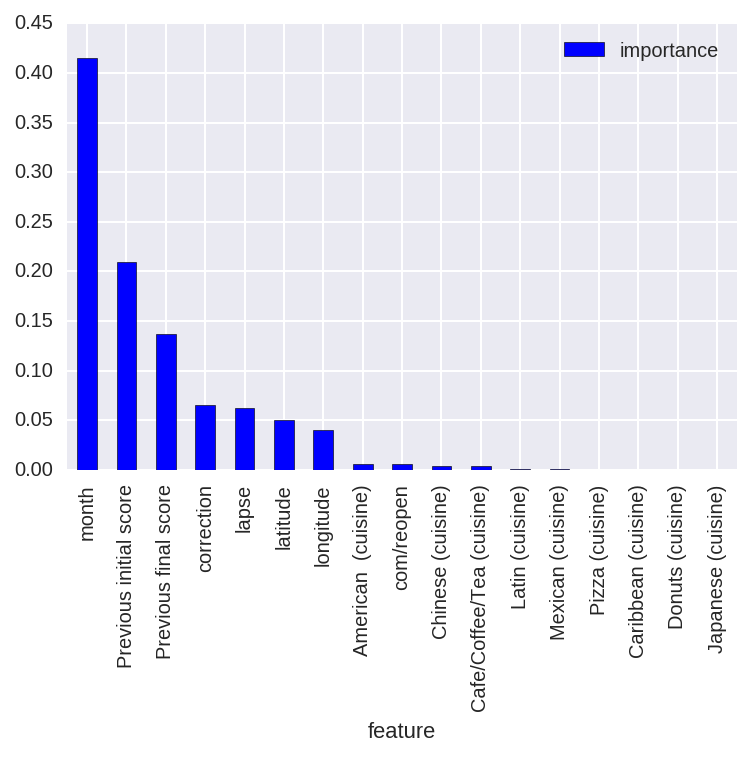

In [71]:
fi = pd.concat([cfimp,ofimp],0).sort_values('importance',ascending=False)
fi.plot(x="feature", y="importance", kind="Bar")

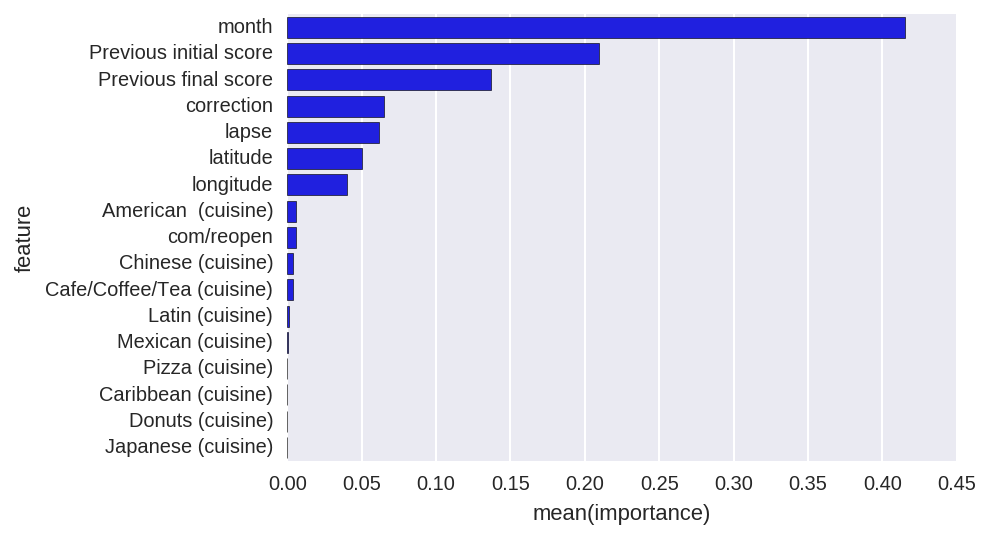

In [129]:
sns.barplot(x="importance",y="feature", data=fi, color="blue")

## Predicted Behavior

In [14]:
var = {'cuisine': 'Chinese','sh_iscore': 30, 'sh_fscore': 20, 'com/reopen': 1, 'lapse': 5,'correction':-10,
       'zipcode': 10011}
vardf = pd.DataFrame(var, index=[0])
#geocode zipcodes
vardf = pd.merge(vardf, zip_latlng, how='left', on='zipcode')
#add month
vardf12 = pd.concat([vardf]*12)
vardf12.loc[:,'month']=np.array(range(1,13))
vardf12

,com/reopen,correction,cuisine,lapse,sh_fscore,sh_iscore,zipcode,latitude,longitude,month
0,1,-10,Chinese,5,20,30,10011,40.746497,-74.009447,1
0,1,-10,Chinese,5,20,30,10011,40.746497,-74.009447,2
0,1,-10,Chinese,5,20,30,10011,40.746497,-74.009447,3
0,1,-10,Chinese,5,20,30,10011,40.746497,-74.009447,4
0,1,-10,Chinese,5,20,30,10011,40.746497,-74.009447,5
0,1,-10,Chinese,5,20,30,10011,40.746497,-74.009447,6
0,1,-10,Chinese,5,20,30,10011,40.746497,-74.009447,7
0,1,-10,Chinese,5,20,30,10011,40.746497,-74.009447,8
0,1,-10,Chinese,5,20,30,10011,40.746497,-74.009447,9
0,1,-10,Chinese,5,20,30,10011,40.746497,-74.009447,10


In [15]:
#predict scores using the model
p_scores = pd.DataFrame(fullmodel.predict(vardf12),columns=['iscore','fscore'])
p_scores.loc[:,'month'] = np.array(range(1,13))

In [16]:
width=1000
height=350
plot = figure(width=width, height=height,
              #tools=TOOLS,
              title='Score variation with time (from model)',
              x_axis_label='Month of year')

        # numlines = len(options)
        # colors=[]
options=['iscore','fscore']
colorselect = dict([('iscore','red'),('fscore','green')])
leg = dict([('iscore','Initial inspection score'),('fscore','Final score')])
        # for item in options:
        #     colors.append(colorselect[item])
        #
for item in options:
    plot.circle(x=p_scores.month, y=p_scores[item], size = 10, fill_color="white", line_color=colorselect[item], 
                         legend = leg[item], line_width=3)
    plot.line(x=p_scores.month, y=p_scores[item], line_color = colorselect[item], legend = leg[item])

plot.legend.orientation = "top_left"
plot.legend.legend_padding = 40

#output_file('Grade_vs_time.html')
show(plot)

## Score history effect

In [ ]:
var = {'cuisine': 'Chinese','sh_iscore': 30, 'sh_fscore': 20, 'com/reopen': 1, 'lapse': 5,'correction':-10,
       'zipcode': 10011}
vardf = pd.DataFrame(var, index=[0])
#geocode zipcodes
vardf = pd.merge(vardf, zip_latlng, how='left', on='zipcode')
#add month
vardf12 = pd.concat([vardf]*12)
vardf12.loc[:,'month']=np.array(range(1,13))
vardf12

In [ ]:
class DenseTransformer(TransformerMixin):

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

In [11]:
#Gradient boost
class gb_model(BaseEstimator, RegressorMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y):
        #cv = cross_validation.ShuffleSplit(len(y), n_iter=20, test_size=0.2, random_state=42)
    
        param_grid = {"min_samples_leaf": [3,6], "max_depth":[2], "learning_rate":[0.1,0.05,0.01],
                     "max_features": [1, 0.5]}   
        self.gb_cv = grid_search.GridSearchCV(GradientBoostingRegressor(warm_start=True,n_estimators=2000), 
                                                       param_grid=param_grid, 
                                                       scoring='mean_squared_error')
        self.gb_cv.fit(X, y)
        return self
    
    def predict(self, X):
        self.tmp = self.gb_cv.predict(X)
        if len(self.tmp) ==1:
            self.result = self.tmp[0]
        else:
            self.result = self.tmp
        return self.result

In [691]:
fullmodel2 = Pipeline([ ('other', Sh_Latlng_month_Transformer(['sh_iscore','sh_fscore', 'com/reopen', 
                                                               'lapse','correction','latitude',
                                                               'longitude','month'])), ('est', gb_model())])

In [ ]:
ygb_i = y.i_score.values
ygb_f = y.score.values.reshape(-1,1)
fullmodel2.fit(X,ygb_i)

In [ ]:
fullmodel2.named_steps['est'].random_forest_cv.grid_scores_ 

In [ ]:
best_est=fullmodel2.named_steps['est'].random_forest_cv.best_estimator_

In [ ]:
best_est.feature_importances_

In [ ]:
# Plot training deviance
clf = best_est
# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

In [662]:
ctr = Pipeline([('cuisine', CuisineTransformer('cuisine')),('vec',DictVectorizer())])
ts =ctr.fit_transform(X).toarray()

In [657]:
y.i_score.values

array([  6.,  12.,  12., ...,  24.,  12.,  31.])

In [663]:
ts.todense()

AttributeError: 'numpy.ndarray' object has no attribute 'todense'

In [379]:
fullmodel.named_steps['est'].random_forest_cv.grid_scores_ 

[mean: -53.59620, std: 4.50488, params: {'n_estimators': 10, 'min_samples_leaf': 10},
 mean: -53.20551, std: 4.07226, params: {'n_estimators': 20, 'min_samples_leaf': 10},
 mean: -53.00520, std: 4.28542, params: {'n_estimators': 30, 'min_samples_leaf': 10},
 mean: -52.92804, std: 4.20250, params: {'n_estimators': 40, 'min_samples_leaf': 10},
 mean: -52.92295, std: 4.22017, params: {'n_estimators': 50, 'min_samples_leaf': 10},
 mean: -52.92559, std: 4.16800, params: {'n_estimators': 10, 'min_samples_leaf': 30},
 mean: -52.69830, std: 4.20426, params: {'n_estimators': 20, 'min_samples_leaf': 30},
 mean: -52.60410, std: 4.20223, params: {'n_estimators': 30, 'min_samples_leaf': 30},
 mean: -52.57437, std: 4.12303, params: {'n_estimators': 40, 'min_samples_leaf': 30},
 mean: -52.55437, std: 4.17103, params: {'n_estimators': 50, 'min_samples_leaf': 30},
 mean: -52.91589, std: 4.32028, params: {'n_estimators': 10, 'min_samples_leaf': 50},
 mean: -52.62263, std: 4.18785, params: {'n_estimators

In [380]:
fullmodel.named_steps['est'].random_forest_cv.best_score_

-52.515273638190713

In [384]:
fullmodel.predict(X)

array([[  7.43582914,   7.35525809],
       [ 11.14538697,   9.73696878],
       [  9.97537726,   7.02273201],
       ..., 
       [ 15.26598793,  10.51634085],
       [ 10.56599401,   8.98416712],
       [ 13.83535123,  10.03907209]])

In [14]:
best_est = fullmodel.named_steps['est'].random_forest_cv.best_estimator_

In [15]:
best_est.n_features_

91

In [63]:
feature_imp = best_est.feature_importances_
cuisine_imp = feature_imp[:83]
cuisine_name = sorted(list(set(X.cuisine.tolist())))
cfimp = pd.DataFrame(zip(cuisine_name,cuisine_imp),columns=['feature','importance'])
cfimp = cfimp[cfimp.importance!=0]
cfimp.loc[:,'feature']=cfimp.feature.map(lambda x: x+" (cuisine)")

In [64]:
other_imp = feature_imp[83:]
other_name = ['Previous initial score','Previous final score', 'com/reopen', 'lapse','correction','latitude','longitude','month']
ofimp = pd.DataFrame(zip(other_name, other_imp),columns=['feature','importance'])
ofimp

,feature,importance
0,Previous initial score,0.209359
1,Previous final score,0.136641
2,com/reopen,0.005818
3,lapse,0.061764
4,correction,0.065043
5,latitude,0.050304
6,longitude,0.039991
7,month,0.415317


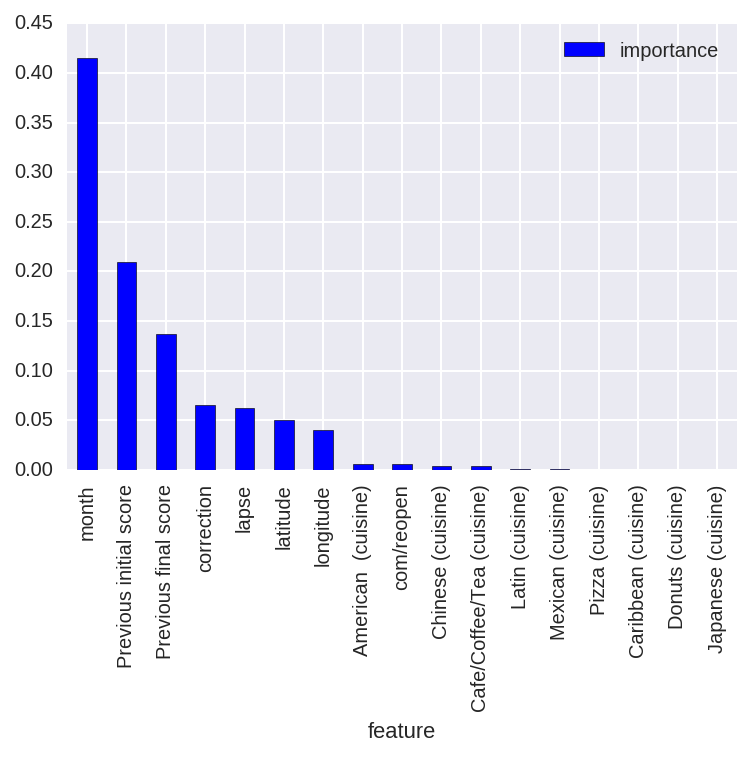

In [65]:
fi = pd.concat([cfimp,ofimp],0).sort_values('importance',ascending=False)
fi.plot(x="feature", y="importance", kind="Bar")

In [400]:
#save the model for future convenience
dill.dump(fullmodel, open('fullmodelx','w'))

In [67]:
fullmodel=dill.load(open('fullmodel','r'))

## Testing Model

In [32]:
X

,CAMIS,sh_iscore,sh_fscore,com/reopen,lapse,correction,cuisine,zipcode,date,latitude,longitude,month
0,30075445,2,2,0,9.000000,-26.000000,Bakery,10462,2015-02-09,40.838252,-73.856609,2
1,30112340,16,8,0,-3.000000,1.000000,Hamburgers,11225,2015-05-07,40.664828,-73.956555,5
2,30191841,2,2,0,-9.000000,0.000000,Irish,10019,2015-09-21,40.768697,-73.991818,9
3,40356018,5,5,0,-2.000000,0.000000,American,11224,2015-06-05,40.574926,-73.985941,6
4,40356151,19,16,0,26.000000,-21.500000,American,11369,2015-05-29,40.765925,-73.868370,5
5,40356483,10,10,0,10.500000,-17.000000,Delicatessen,11234,2015-05-08,40.600796,-73.906588,5
6,40356649,12,12,0,0.500000,-5.000000,American,11219,2015-07-21,40.631075,-73.997695,7
7,40356731,12,12,0,4.000000,0.000000,"Ice Cream, Gelato, Yogurt, Ices",11226,2015-06-26,40.647092,-73.953616,6
8,40357217,11,11,0,7.000000,0.000000,American,10460,2015-05-06,40.841618,-73.880130,5
9,40358429,30,19,0,1.000000,-3.000000,Chinese,11208,2015-07-08,40.674934,-73.871310,7


In [21]:
y_predict = fullmodel.predict(X)

In [23]:
#convert to pandas
y_pd = pd.DataFrame(y_predict,columns=["p_iscore","p_score"])
#y_pd = pd.DataFrame(y_predict,columns=["p_iscore"])
#combine with X,y

Xyp = pd.concat([Xy.reset_index(),y_pd],1)

In [28]:
colors = ['#fff5f0','#fee0d2','#fcbba1','#fc9272','#fb6a4a','#ef3b2c','#cb181d','#a50f15','#67000d']
def choose_color(score):
    if score>=54:
        i=8
    else:
        i= int(score//6)
    return colors[i]

Xyp.loc[:,'icolor']=Xyp.i_score.map(choose_color)
Xyp.loc[:,'color']=Xyp.score.map(choose_color)
Xyp.loc[:,'p_icolor']=Xyp.p_iscore.map(choose_color)
Xyp.loc[:,'p_color']=Xyp.p_score.map(choose_color)
Xyp

,CAMIS,sh_iscore,sh_fscore,com/reopen,lapse,correction,cuisine,zipcode,date,i_score,score,month,p_iscore,p_score,icolor,color,p_icolor,p_color
0,30075445,2,2,0,9.000000,-26.000000,Bakery,10462,2015-02-09,6,6,2,7.435829,7.355258,#fee0d2,#fee0d2,#fee0d2,#fee0d2
1,30112340,16,8,0,-3.000000,1.000000,Hamburgers,11225,2015-05-07,12,12,5,11.145387,9.736969,#fcbba1,#fcbba1,#fee0d2,#fee0d2
2,30191841,2,2,0,-9.000000,0.000000,Irish,10019,2015-09-21,12,8,9,9.975377,7.022732,#fcbba1,#fee0d2,#fee0d2,#fee0d2
3,40356018,5,5,0,-2.000000,0.000000,American,11224,2015-06-05,4,4,6,12.977681,8.847347,#fff5f0,#fff5f0,#fcbba1,#fee0d2
4,40356151,19,16,0,26.000000,-21.500000,American,11369,2015-05-29,11,12,5,14.213368,11.242546,#fee0d2,#fcbba1,#fcbba1,#fee0d2
5,40356483,10,10,0,10.500000,-17.000000,Delicatessen,11234,2015-05-08,9,9,5,10.591096,9.324326,#fee0d2,#fee0d2,#fee0d2,#fee0d2
6,40356649,12,12,0,0.500000,-5.000000,American,11219,2015-07-21,25,8,7,15.800448,10.365175,#fb6a4a,#fee0d2,#fcbba1,#fee0d2
7,40356731,12,12,0,4.000000,0.000000,"Ice Cream, Gelato, Yogurt, Ices",11226,2015-06-26,5,5,6,13.707724,9.644530,#fff5f0,#fff5f0,#fcbba1,#fee0d2
8,40357217,11,11,0,7.000000,0.000000,American,10460,2015-05-06,9,9,5,9.567288,8.193772,#fee0d2,#fee0d2,#fee0d2,#fee0d2
9,40358429,30,19,0,1.000000,-3.000000,Chinese,11208,2015-07-08,34,10,7,22.345906,13.732548,#ef3b2c,#fee0d2,#fc9272,#fcbba1


In [29]:
testX = Xyp[Xyp.month==3]
testX

,CAMIS,sh_iscore,sh_fscore,com/reopen,lapse,correction,cuisine,zipcode,date,i_score,score,month,p_iscore,p_score,icolor,color,p_icolor,p_color
18,40361998,3,3,0,-9.000000,0.000000,Delicatessen,11106,2015-03-04,2,2,3,7.022914,6.922513,#fff5f0,#fff5f0,#fee0d2,#fee0d2
20,40362264,24,26,1,1.500000,-6.333333,American,10025,2015-03-19,13,13,3,13.553486,11.721539,#fcbba1,#fcbba1,#fcbba1,#fee0d2
22,40362432,10,10,0,8.000000,-13.000000,Chinese,11368,2015-03-31,12,12,3,8.774443,8.545139,#fcbba1,#fcbba1,#fee0d2,#fee0d2
46,40364286,13,12,0,3.000000,-11.000000,Delicatessen,10306,2015-03-26,13,13,3,11.129716,9.459353,#fcbba1,#fcbba1,#fee0d2,#fee0d2
51,40364335,12,12,0,5.500000,-28.500000,Steak,11211,2015-03-13,11,11,3,10.430705,9.607427,#fee0d2,#fee0d2,#fee0d2,#fee0d2
62,40364529,11,11,0,9.000000,-7.000000,Jewish/Kosher,11374,2015-03-02,11,11,3,9.275214,8.850149,#fee0d2,#fee0d2,#fee0d2,#fee0d2
64,40364572,12,12,0,4.000000,0.000000,Steak,10065,2015-03-10,9,9,3,9.327244,8.855686,#fee0d2,#fee0d2,#fee0d2,#fee0d2
100,40365546,18,8,0,3.000000,-6.333333,American,11211,2015-03-02,7,7,3,9.473713,9.227240,#fee0d2,#fee0d2,#fee0d2,#fee0d2
121,40366054,11,11,0,-1.000000,-15.000000,American,11694,2015-03-30,12,12,3,10.240819,9.590582,#fcbba1,#fcbba1,#fee0d2,#fee0d2
135,40366473,9,15,0,-3.000000,6.000000,Seafood,10014,2015-03-20,7,7,3,11.217568,10.362975,#fee0d2,#fee0d2,#fee0d2,#fee0d2


In [31]:
source = ColumnDataSource(dict(sh_iscore=testX.sh_iscore, sh_fscore=testX.sh_fscore, i_score=testX.i_score,
                              score=testX.score, p_iscore=testX.p_iscore, p_score=testX.p_score, i_color=testX.icolor,
                              color=testX.color, p_icolor=testX.p_icolor, p_color=testX.p_color))

#initial_circle = Circle(x='x', y='y', fill_color='blue', size=50)

def scattercolor(source, which):
    p = figure(title=("test"),
            x_axis_location="below", plot_width=900, plot_height=400,
            toolbar_location="left")
    p.circle("sh_iscore", "sh_fscore", source=source, color = which+"color", line_color=None)
    
    hover = p.select(dict(type=HoverTool))
    hover.tooltips = OrderedDict([
        ('Previous initial score', '@sh_iscore'),
        ('Previous final score', '@sh_fscore'),
        ('score', '@'+which+"score"),
    ])
    return p

#plottmp = drawheatmap(source, "t")

tab1 = Panel(child=scattercolor(source, "i_"), title="Initial Score")
tab2 = Panel(child=scattercolor(source, ""), title="Final Score")
tab3 = Panel(child=scattercolor(source, "p_i"), title="Predicted initial score")
tab4 = Panel(child=scattercolor(source, "p_"), title="Predicted final score")

tabs = Tabs(tabs=[ tab1, tab2, tab3, tab4 ])

show(tabs)

In [27]:
source = ColumnDataSource(dict(sh_iscore=testX.sh_iscore, sh_fscore=testX.sh_fscore, i_score=testX.i_score,
                              score=testX.score, p_iscore=testX.p_iscore, i_color=testX.icolor,
                              color=testX.color, p_icolor=testX.p_icolor))

#initial_circle = Circle(x='x', y='y', fill_color='blue', size=50)

def scattercolor(source, which):
    p = figure(title=("test"),
            x_axis_location="below", plot_width=900, plot_height=400,
            toolbar_location="left", tools=TOOLS)
    p.circle("sh_iscore", "sh_fscore", source=source, color = which+"color", line_color=None)
    
    hover = p.select(dict(type=HoverTool))
    hover.tooltips = OrderedDict([
        ('Previous initial score', '@sh_iscore'),
        ('Previous final score', '@sh_fscore'),
        ('score', '@'+which+"score"),
    ])
    return p

#plottmp = drawheatmap(source, "t")

tab1 = Panel(child=scattercolor(source, "i_"), title="Initial Score")
tab2 = Panel(child=scattercolor(source, ""), title="Final Score")
tab3 = Panel(child=scattercolor(source, "p_i"), title="Predicted initial score")
tab4 = Panel(child=scattercolor(source, "p_"), title="Predicted final score")

tabs = Tabs(tabs=[ tab1, tab2, tab3, tab4 ])

show(tabs)

NameError: global name 'TOOLS' is not defined

## Plotting score history effects

In [34]:
var = {'cuisine': 'Chinese', 'com/reopen': 1, 'lapse': 5,'correction':-10,
       'zipcode': 10011}
vardf = pd.DataFrame(var, index=[0])
#geocode zipcodes
vardf = pd.merge(vardf, zip_latlng, how='left', on='zipcode')
#add month
vardf12 = pd.concat([vardf]*3600)

vardf12

,com/reopen,correction,cuisine,lapse,zipcode,latitude,longitude
0,1,-10,Chinese,5,10011,40.746497,-74.009447
0,1,-10,Chinese,5,10011,40.746497,-74.009447
0,1,-10,Chinese,5,10011,40.746497,-74.009447
0,1,-10,Chinese,5,10011,40.746497,-74.009447
0,1,-10,Chinese,5,10011,40.746497,-74.009447
0,1,-10,Chinese,5,10011,40.746497,-74.009447
0,1,-10,Chinese,5,10011,40.746497,-74.009447
0,1,-10,Chinese,5,10011,40.746497,-74.009447
0,1,-10,Chinese,5,10011,40.746497,-74.009447
0,1,-10,Chinese,5,10011,40.746497,-74.009447


In [601]:
p = Scatter(testX, x='sh_iscore', y='sh_fscore', full_color='icolor',
            title="Initial inspection scores", legend="top_left",
            xlabel="Previous initial score", ylabel="Previous final score")

show(p)

AttributeError: unexpected attribute 'full_color' to ChartOptions, possible attributes are filename, height, id, legend, name, notebook, responsive, server, session, tags, title, title_text_font_size, tools, width, xgrid, xlabel, xscale, ygrid, ylabel or yscale

In [472]:
p = Scatter(testX, x='sh_iscore', y='sh_fscore', color='p_icolor',
            title="Initial inspection scores", legend="top_left",
            xlabel="Previous initial score", ylabel="Previous final score")

show(p)

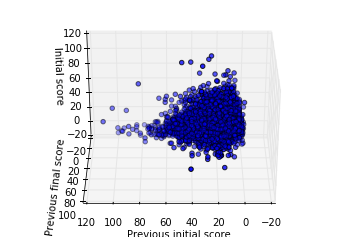

In [448]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib inline 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs=Xyp.sh_iscore.values
ys=Xyp.sh_fscore.values
zs=Xyp.i_score.values
zsp=Xyp.p_iscore.values

ax.scatter(xs, ys, zs, c='b', marker='o')
#ax.scatter(xs, ys, zsp, c='r', marker='^')
#ax.plot_surface(xs, ys, zsp, rstride=1, cstride=1, cmap=cm.coolwarm,
#                       linewidth=0, antialiased=False)

#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

ax.set_xlabel('Previous initial score')
ax.set_ylabel('Previous final score')
ax.set_zlabel('Initial score')

ax.view_init(30, 90)
plt.draw()

In [412]:
Xyp

,CAMIS,sh_iscore,sh_fscore,com/reopen,lapse,correction,cuisine,zipcode,date,i_score,score,p_iscore,p_score
0,30075445,2,2,0,9.000000,-26.000000,Bakery,10462,2015-02-09,6,6,7.435829,7.355258
1,30112340,16,8,0,-3.000000,1.000000,Hamburgers,11225,2015-05-07,12,12,11.145387,9.736969
2,30191841,2,2,0,-9.000000,0.000000,Irish,10019,2015-09-21,12,8,9.975377,7.022732
3,40356018,5,5,0,-2.000000,0.000000,American,11224,2015-06-05,4,4,12.977681,8.847347
4,40356151,19,16,0,26.000000,-21.500000,American,11369,2015-05-29,11,12,14.213368,11.242546
5,40356483,10,10,0,10.500000,-17.000000,Delicatessen,11234,2015-05-08,9,9,10.591096,9.324326
6,40356649,12,12,0,0.500000,-5.000000,American,11219,2015-07-21,25,8,15.800448,10.365175
7,40356731,12,12,0,4.000000,0.000000,"Ice Cream, Gelato, Yogurt, Ices",11226,2015-06-26,5,5,13.707724,9.644530
8,40357217,11,11,0,7.000000,0.000000,American,10460,2015-05-06,9,9,9.567288,8.193772
9,40358429,30,19,0,1.000000,-3.000000,Chinese,11208,2015-07-08,34,10,22.345906,13.732548


In [416]:
type(Xyp.sh_iscore.values)

numpy.ndarray

In [333]:
test = CuisineTransformer('cuisine')
test2 =test.fit_transform(X)
dvv = DictVectorizer()

In [338]:
dvv.fit_transform(test2)

<18346x83 sparse matrix of type '<type 'numpy.float64'>'
	with 18346 stored elements in Compressed Sparse Row format>

In [341]:
featureunion.fit_transform(X).toarray()

array([[  0.       ,   0.       ,   0.       , ...,  40.8382522,
        -73.8566087,   2.       ],
       [  0.       ,   0.       ,   0.       , ...,  40.6648278,
        -73.9565551,   5.       ],
       [  0.       ,   0.       ,   0.       , ...,  40.7686973,
        -73.9918181,   9.       ],
       ..., 
       [  0.       ,   0.       ,   0.       , ...,  40.6648278,
        -73.9565551,  11.       ],
       [  0.       ,   0.       ,   1.       , ...,  40.755322 ,
        -73.9932872,  12.       ],
       [  0.       ,   0.       ,   0.       , ...,  40.7699016,
        -73.8272029,  12.       ]])

In [344]:
len(yy)

18348